# 2. Projekat iz predmeta **Mašinsko učenje**
**Dataset:**  
[E-commerce Cosmetic Products](https://www.kaggle.com/datasets/devi5723/e-commerce-cosmetics-dataset)

U ovom projektu bavimo se problemom klasterizacije podataka, sa ciljem identifikacije sličnih proizvoda u e-commerce okruženju. 
Skup podataka sadrži informacije o kozmetičkim proizvodima koji se prodaju putem online platformi, uključujući njihove cenovne karakteristike, popularnost i osnovne opisne atribute.

## Osobine (feature-i)
Za potrebe klasterizacije korišćen je podskup atributa koji su relevantni za segmentaciju proizvoda u e-commerce sistemu:
- Price - cena proizvoda
- Rating - prosečna ocena proizvoda
- Number of Ratings - broj korisničkih ocena 
- Category - glavna kategorija proizvoda
- Subcategory - podkategorija proizvoda

Numeričke osobine korišćene su za analizu cenovnog ranga i popularnosti proizvoda, dok su kategorijske osobine omogućile grupisanje proizvoda prema njihovim osnovnim karakteristikama.

Cilj ovog projekta je primena i upoređivanje različitih algoritama za klasterizaciju u cilju:
identifikacije različitih tržišnih segmenata proizvoda (npr. niskobudžetni, srednji i premium proizvodi),
analize sličnosti između proizvoda na osnovu cene, popularnosti i osnovnih karakteristika,
ispitivanja uticaja preprocesiranja podataka, redukcije dimenzionalnosti i obrade outlier-a na kvalitet dobijenih klastera.

Očekivani klasteri:                                                                                                                                            
  1. Premium Quality - visoka cena, visok rating, manje recenzija                                                                                                
  2. Bestsellers - srednja cena, visok rating, mnogo recenzija                                                                                                  
  3. Budget Friendly - niska cena, okej rating, dosta recenzija                                                                                                  
  4. Overpriced - visoka cena, nizak rating                                                                                                          
  5. Hidden Gems - niska cena, visok rating, malo recenzija   

## Setup i učitavanje
### Import biblioteka i setovanje konstantni

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# Paleta boja: roze, plava, ljubičasta
COLORS = {
    'pink': '#E91E63',
    'pink_light': '#F48FB1',
    'purple': '#9C27B0',
    'purple_light': '#CE93D8',
    'blue': '#5C6BC0',
    'blue_light': '#9FA8DA',
}

COLOR_PALETTE = ['#E91E63', '#9C27B0', '#5C6BC0', '#F48FB1', '#CE93D8', '#9FA8DA']

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

### Učitavanje podataka i pregled strukture

In [203]:
dataset = pd.read_csv('data/E-commerce-cosmetic-dataset.csv', encoding='latin-1')

dataset.info()

dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12615 entries, 0 to 12614
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  12615 non-null  object 
 1   website       12615 non-null  object 
 2   country       12615 non-null  object 
 3   category      12615 non-null  object 
 4   subcategory   12615 non-null  object 
 5   title-href    12615 non-null  object 
 6   price         12298 non-null  float64
 7   brand         12615 non-null  object 
 8   ingredients   6600 non-null   object 
 9   form          12615 non-null  object 
 10  type          9934 non-null   object 
 11  color         10626 non-null  object 
 12  size          9449 non-null   object 
 13  rating        10548 non-null  object 
 14  noofratings   12156 non-null  object 
dtypes: float64(1), object(14)
memory usage: 1.4+ MB


,price
count,12298.000000
mean,2281.180935
std,3158.690307
min,1.700000
25%,499.000000
50%,1307.200000
75%,2859.500000
max,94099.000000


In [204]:
dataset.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100,3.9,19
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,031"
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,072"
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,Denver,NaN,aerosol,NaN,Long-Lasting Scent,60,4.2,61
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,Denver,NaN,aerosol,NaN,Long-Lasting Scent,100,4.3,342


## Preprocesiranje podataka

### Uklanjanje duplikata

In [205]:
broj_duplikata = dataset.duplicated().sum()
print(f'Broj duplikata: {broj_duplikata}')
dataset = dataset.drop_duplicates()
print(f'Broj redova posle uklanjanja: {len(dataset)}')

Broj duplikata: 60
Broj redova posle uklanjanja: 12555


### Konverzija valute (INR → EUR)

Dataset sadrži cene u indijskim rupijama (INR). Konvertujemo u evre (EUR) za lakšu interpretaciju.

In [206]:
INR_TO_EUR = 0.0094

dataset['price'] = dataset['price'] * INR_TO_EUR

print(f"\nStatistika cena u EUR:")
dataset.describe()


Statistika cena u EUR:


,price
count,12238.000000
mean,21.485583
std,29.751437
min,0.015980
25%,4.690600
50%,12.287680
75%,26.879300
max,884.530600


### Uklanjanje nerelevantnih fičera
- Url do proizvoda
- Type i Form - već postoji kategorija i podkategorija
- Color - nerelevanta, takođe ima netačne vrednosti za tu kolonu

In [207]:
dataset = dataset.drop(columns=['title-href', 'type', 'color', 'form'])


### Preprocesiranje kolona Rating i Number of Ratings
Kolone Rating i Number of Ratings su mešovite: 
- Number of Ratings sadrži vrednosti kao što su "No reviews", "New to Amazon", "Write a review", "X ratings" (X - broj ocena) i numeričke vrednosti.
- Rating sadrži vrednosti kao što su "X out of 5 stars"(X - vrednost ocene) i numeričke vrednosti gde nisu sve u opsegu od 1-5.

In [208]:
noofratings_filters = {
    'No reviews': dataset['noofratings'].astype(str).str.lower().str.contains('no review', na=False),
    'New to Amazon': dataset['noofratings'].astype(str).str.lower().str.contains('new to amazon', na=False),
    'Write a review': dataset['noofratings'].astype(str).str.lower().str.contains('write a review', na=False),
    'X ratings (string)': dataset['noofratings'].astype(str).str.contains('rating', case=False, na=False),
    'Broj sa zarezom': dataset['noofratings'].astype(str).str.match(r'^\d+,\d+$', na=False),
}

rows = []
for opis, filter_mask in noofratings_filters.items():
    if filter_mask.sum() > 0:
        row = dataset[filter_mask][['product_name', 'rating', 'noofratings']].head(1).copy()
        row.insert(0, 'Tip vrednosti', opis)
        rows.append(row)

noofratings_examples = pd.concat(rows, ignore_index=True)
display(noofratings_examples)

rating_filters = {
    'X out of 5 stars': dataset['rating'].astype(str).str.contains('out of 5', case=False, na=False),
    'Vrednost sa zarezom': dataset['rating'].astype(str).str.contains(r'^\d,\d+$', regex=True, na=False),
    'Vrednost > 5': pd.to_numeric(dataset['rating'], errors='coerce') > 5,
}

rows = []
for opis, filter_mask in rating_filters.items():
    if filter_mask.sum() > 0:
        row = dataset[filter_mask][['product_name', 'rating', 'noofratings']].head(1).copy()
        row.insert(0, 'Tip vrednosti', opis)
        rows.append(row)

rating_examples = pd.concat(rows, ignore_index=True)
display(rating_examples)

,Tip vrednosti,product_name,rating,noofratings
0,No reviews,Adbeni WATERPROFF LENGTH FIBER EXTENSION EYELI...,NaN,No reviews
1,New to Amazon,ATORSE Eyelash Eyebrow Dye Tint Cream Kit Eyeb...,NaN,New to Amazon
2,Write a review,Sweet Tobacco Spirits Spritzer,NaN,Write A Review
3,X ratings (string),Swiss Beauty High Coverage Waterproof Base Fou...,3.80,"1,165 ratings"
4,Broj sa zarezom,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,4.4,"4,031"


,Tip vrednosti,product_name,rating,noofratings
0,X out of 5 stars,Supra Concealer Opaque Coverage Professional M...,2.8 out of 5 stars,10 ratings
1,Vrednost sa zarezom,Body Cupid Matcha Green Tea Shower Gel - 200,"1,374",NaN
2,Vrednost > 5,Kimirica Creme Bath Tropical Forest Summer Bod...,134,NaN


**Kolona Rating zavisi od Number of Ratings**
ako ne postoje ocene(na primer novi proizvod na sajtu), vrednost za Rating je prazno polje. 
- Uklanjaju se ocene koje prevazilaze vrednost 5 - ne možemo sa sigurnošću da ih obradimo sa 100% tačnošću.
- Stringovi u Number of Ratings se transformišu u numeričke vrednosti - izvlači se podatak o broju ocene iz stringa ili se dodeljuje vrednost 0.
- Uvodimo kolonu Has Reviews koja će razdvajati loše ocenjene proizvode od novih proizvoda ili proizvoda bez ocena.

In [209]:
def clean_noofratings(value):
    if pd.isna(value):
        return np.nan
    
    value = str(value).strip().lower()
    
    zero_indicators = ['no reviews', 'write a review', 'new to amazon', 'be the first to review', '']
    if value in zero_indicators:
        return 0
    
    value = value.replace('ratings', '').replace('rating', '').strip()
    value = value.replace(',', '')
    
    try:
        return int(float(value))
    except ValueError:
        return np.nan

def clean_rating(value):
    if pd.isna(value):
        return np.nan

    value_str = str(value).strip().replace(',', '.')

    try:
        rating = float(value_str)
    except ValueError:
        return np.nan

    if rating < 1.0 or rating > 5.0:
        return np.nan

    return rating

print("Pre čišćenja:")
print(f"  rating:      {dataset['rating'].notna().sum()} non-null, tip: {dataset['rating'].dtype}")
print(f"  noofratings: {dataset['noofratings'].notna().sum()} non-null, tip: {dataset['noofratings'].dtype}")

dataset['noofratings'] = dataset['noofratings'].apply(clean_noofratings)
dataset['noofratings'] = dataset['noofratings'].astype('Int64')

dataset['rating'] = dataset['rating'].apply(clean_rating)

dataset['has_reviews'] = (dataset['noofratings'].fillna(0) > 0).astype(int)

dataset.loc[(dataset['noofratings'] == 0) | (dataset['noofratings'].isna()), 'rating'] = np.nan

print("\nPosle čišćenja:")
print(f"  rating:      {dataset['rating'].notna().sum()} non-null, tip: {dataset['rating'].dtype}")
print(f"  noofratings: {dataset['noofratings'].notna().sum()} non-null, tip: {dataset['noofratings'].dtype}")
print(f"  has_reviews: nova kolona kreirana")

print("\nSTATISTIKE POSLE ČIŠĆENJA:")
print(dataset[['price', 'rating', 'noofratings']].describe())

print("\nRATING KOLONA - SADA U OPSEGU 1.0-5.0:")
print(f"Min: {dataset['rating'].min():.2f}")
print(f"Max: {dataset['rating'].max():.2f}")
print(f"Mean: {dataset['rating'].mean():.2f}")

Pre čišćenja:
  rating:      10494 non-null, tip: object
  noofratings: 12102 non-null, tip: object

Posle čišćenja:
  rating:      10391 non-null, tip: float64
  noofratings: 12102 non-null, tip: Int64
  has_reviews: nova kolona kreirana

STATISTIKE POSLE ČIŠĆENJA:
              price        rating  noofratings
count  12238.000000  10391.000000      12102.0
mean      21.485583      4.137172  1036.605354
std       29.751437      0.525300  6705.413616
min        0.015980      1.000000          0.0
25%        4.690600      4.000000          8.0
50%       12.287680      4.200000         31.0
75%       26.879300      4.500000       289.75
max      884.530600      5.000000     220040.0

RATING KOLONA - SADA U OPSEGU 1.0-5.0:
Min: 1.00
Max: 5.00
Mean: 4.14


In [210]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12555 entries, 0 to 12614
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  12555 non-null  object 
 1   website       12555 non-null  object 
 2   country       12555 non-null  object 
 3   category      12555 non-null  object 
 4   subcategory   12555 non-null  object 
 5   price         12238 non-null  float64
 6   brand         12555 non-null  object 
 7   ingredients   6547 non-null   object 
 8   size          9409 non-null   object 
 9   rating        10391 non-null  float64
 10  noofratings   12102 non-null  Int64  
 11  has_reviews   12555 non-null  int64  
dtypes: Int64(1), float64(2), int64(1), object(8)
memory usage: 1.3+ MB


### Analiza podataka

#### Analiza nedostajućih vrednosti

Nedostajuće vrednosti po kolonama:

             Nedostaje  Procenat (%)
ingredients       6008         47.85
size              3146         25.06
rating            2164         17.24
noofratings        453          3.61
price              317          2.52


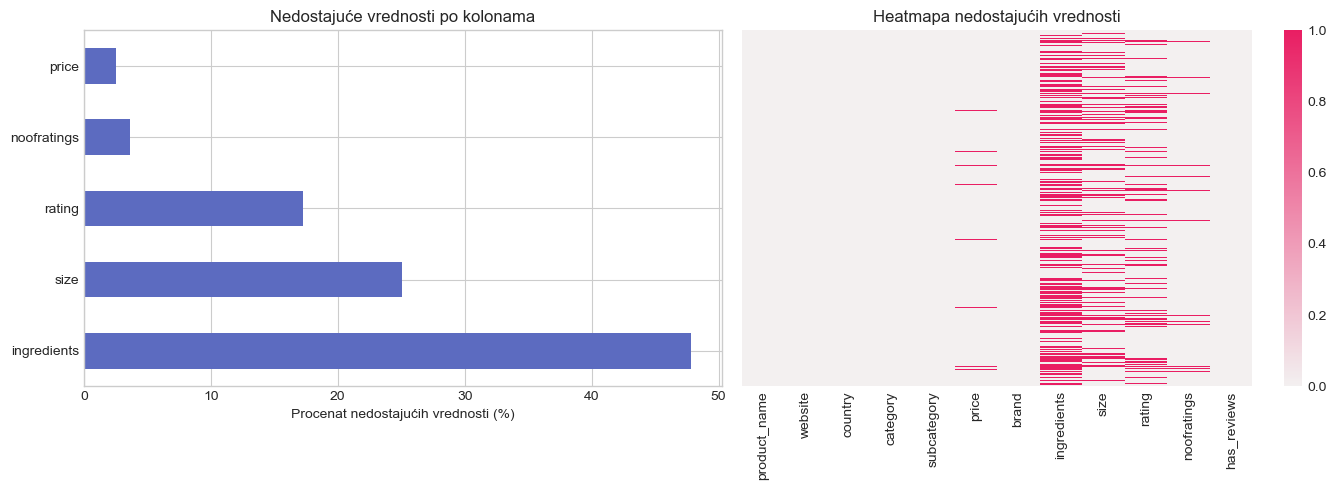

In [211]:
missing_data = pd.DataFrame({
    'Nedostaje': dataset.isnull().sum(),
    'Procenat (%)': (dataset.isnull().sum() / len(dataset) * 100).round(2)
}).sort_values(by='Nedostaje', ascending=False)

print("Nedostajuće vrednosti po kolonama:\n")
print(missing_data[missing_data['Nedostaje'] > 0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

missing_data[missing_data['Nedostaje'] > 0]['Procenat (%)'].plot(
    kind='barh', 
    ax=axes[0],
    color=COLORS['blue']
)
axes[0].set_xlabel('Procenat nedostajućih vrednosti (%)')
axes[0].set_title('Nedostajuće vrednosti po kolonama')

sample_idx = np.random.choice(len(dataset), size=len(dataset), replace=False)
cmap_custom = sns.light_palette(COLORS['pink'], as_cmap=True)
sns.heatmap(
    dataset.iloc[sample_idx].isnull(), 
    cbar=True, 
    yticklabels=False, 
    cmap=cmap_custom,
    ax=axes[1]
)
axes[1].set_title('Heatmapa nedostajućih vrednosti')

plt.tight_layout()
plt.show()

In [212]:
n_total = len(dataset)
has_rating = dataset['rating'].notna()
has_noofratings = dataset['noofratings'].notna()
noofratings_is_0 = (dataset['noofratings'] == 0)  
noofratings_is_na = dataset['noofratings'].isna()

rating_prazan_jer_noofratings_0 = (~has_rating) & noofratings_is_0
rating_prazan_jer_noofratings_na = (~has_rating) & noofratings_is_na
rating_prazan_ostalo = (~has_rating) & has_noofratings & (dataset['noofratings'] > 0)

rating_noofratings_prazni = (~has_rating) & (~has_noofratings )

tabela_odnos = pd.DataFrame({
    'Opis': [
        'Redova bez vrednosti za rating (prazan rating)',
        'rating prazan jer je noofratings = 0',
        'rating prazan jer je noofratings = NA',
        'rating prazan iz drugih razloga (npr. van opsega)',
        'Redova sa vrednošću za noofratings (non-null)',
        'Redova sa noofratings = 0',
        'Redova sa noofratings = NA',
        'Redova sa noofratings > 0 (ima bar jednu ocenu)',
        'Redova gde su rating i noofratings prazni',
    ],
    'Broj redova': [
        (~has_rating).sum(),
        rating_prazan_jer_noofratings_0.sum(),
        rating_prazan_jer_noofratings_na.sum(),
        rating_prazan_ostalo.sum(),
        has_noofratings.sum(),
        noofratings_is_0.sum(),
        noofratings_is_na.sum(),
        (has_noofratings & (dataset['noofratings'] > 0)).sum(),
        rating_noofratings_prazni.sum(),
    ]
})
print("Odnos broja redova: rating i noofratings (podela: 0 vs NA)")
display(tabela_odnos)

Odnos broja redova: rating i noofratings (podela: 0 vs NA)


,Opis,Broj redova
0,Redova bez vrednosti za rating (prazan rating),2164
1,rating prazan jer je noofratings = 0,1417
2,rating prazan jer je noofratings = NA,453
3,rating prazan iz drugih razloga (npr. van opsega),294
4,Redova sa vrednošću za noofratings (non-null),12102
5,Redova sa noofratings = 0,1417
6,Redova sa noofratings = NA,453
7,Redova sa noofratings > 0 (ima bar jednu ocenu),10685
8,Redova gde su rating i noofratings prazni,453


Broj redova gde je rating prazan iz drugih razloga predstavlja mali procenat dataseta (<5%) i može se obrisati

In [213]:
rating_noofratings_prazni = (~has_rating) & noofratings_is_na
n_obrisano_prazni = rating_noofratings_prazni.sum()
redovi_za_izbaciti = rating_prazan_ostalo | rating_noofratings_prazni
dataset = dataset[~redovi_za_izbaciti].copy()
print(f"\nObrisano {rating_prazan_ostalo.sum()} redova (rating prazan uz noofratings > 0).")
print(f"Obrisano {n_obrisano_prazni} redova (nema ni rating ni number of ratings).")
print(f"Ukupno uklonjeno: {redovi_za_izbaciti.sum()} redova. Preostalo: {len(dataset)}")


Obrisano 294 redova (rating prazan uz noofratings > 0).
Obrisano 453 redova (nema ni rating ni number of ratings).
Ukupno uklonjeno: 747 redova. Preostalo: 11808


### Brisanje neupotrebljivih fičera
- Ingredients - veliki procenat nedostajućih vrednosti, metode za popunjavanje praznih vrednosti bi unele samo šum


In [214]:
dataset = dataset.drop(columns=['ingredients'])

#### Analiza Size kolone

Podaci u Size koloni su mešoviti i nepouzdani, u koloni postoje:
- vrednosti koje sadrže informaciju o mernoj jedinici(s, g, Gm, oz, fluid ounces, Kilos, milis)
- vrednosti bez informacije o mernoj jedinici <br>
Takođe, informacija size može da se pronađe unutar samog imena proizvoda, tj. u koloni Product Name, ali se ovi podaci ne poklapaju sa podacima iz kolone Size.

In [215]:
size_filters = {
    'Sa mernom jedinicom (fluid ounces)': dataset['size'].astype(str).str.contains('fluid|ounce', case=False, na=False),
    'Sa mernom jedinicom (Kilos)': dataset['size'].astype(str).str.contains('Kilos', case=False, na=False),
    'Sa mernom jedinicom (g / ml)': dataset['size'].astype(str).str.contains(r'\bg\b|ml|milis|Gm', case=False, regex=True, na=False),
    'Bez mernog jedinice (samo broj)': dataset['size'].astype(str).str.match(r'^\s*\d+\s*$', na=False),
    'Tekst koji nije veličina (npr. Unit count type)': dataset['size'].astype(str).str.contains('Unit count', case=False, na=False),
}

rows = []
for opis, filter_mask in size_filters.items():
    if filter_mask.sum() > 0:
        row = dataset[filter_mask][['product_name', 'size']].head(1).copy()
        row.insert(0, 'Tip vrednosti', opis)
        rows.append(row)

import re
def clear_name_size_mismatch(row):
    name = str(row['product_name'])
    size_val = str(row['size']).strip()
    if not size_val or size_val == 'nan': return False

    after_comma = re.findall(r',\s*(\d+)\s*$', name)     
    after_dash = re.findall(r'\s-\s*(\d+)\s*(\|\s*)?$', name)  
    nums_at_end = after_comma + [t[0] for t in after_dash]
    if not nums_at_end: return False
    size_num_match = re.match(r'^([\d.]+)', size_val)
    size_num_str = size_num_match.group(1) if size_num_match else size_val
    if size_num_str in nums_at_end or size_val in nums_at_end:
        return False
    try:
        size_num_f = float(size_num_str)
        for n in nums_at_end:
            if abs(size_num_f - int(n)) < 2: 
                return False
    except ValueError:
        pass
    return True
mismatch_mask = dataset.apply(clear_name_size_mismatch, axis=1)
if mismatch_mask.sum() > 0:
    row = dataset[mismatch_mask][['product_name', 'size']].head(1).copy()
    row.insert(0, 'Tip vrednosti', 'Size u imenu proizvoda ne poklapa se sa kolonom Size')
    rows.append(row)

size_examples = pd.concat(rows, ignore_index=True)
pd.set_option('display.max_colwidth', None)
display(size_examples)
pd.set_option('display.max_colwidth', 50) 

,Tip vrednosti,product_name,size
0,Sa mernom jedinicom (fluid ounces),Ajmal Aristocrat EDP 75 Long Lasting Scent Spray Fresh Perfume Gift For Men - Made In Dubai,2.5 Fluid Ounces
1,Sa mernom jedinicom (Kilos),Diego dalla Palma Milano Uv Daily Primer Make-Up Base Uv Spf 50+ Pa++++ Transparent,0.17 Kilos
2,Bez mernog jedinice (samo broj),"Carlton London Incense Eau da parfum, Premium Long Lasting & Refreshing Perfume for Men - 100",100
3,Size u imenu proizvoda ne poklapa se sa kolonom Size,"FERRARI Scuderia Forte Eau De Perfume for him, 125",30


Broj redova gde size može da se koristi

In [216]:
size_has_unit = (
    dataset['size'].astype(str).str.contains(r'\bg\b|Gm|oz|fluid|ounce|Kilos|milis|ml|mL', case=False, regex=True, na=False)
)
n_size_with_unit = size_has_unit.sum()
print(f"Broj redova gde kolona Size sadrži mernu jedinicu (g, Gm, oz, fluid ounces, Kilos, milis, ml): {n_size_with_unit}")

def has_size_in_name(name):
    name = str(name)
    after_comma = re.findall(r',\s*(\d+)\s*$', name)
    after_dash = re.findall(r'\s-\s*(\d+)\s*(\|\s*)?$', name)
    return bool(after_comma or after_dash)

name_has_size = dataset['product_name'].apply(has_size_in_name)
n_name_with_size = name_has_size.sum()
print(f"Broj redova gde product_name na kraju sadrži veličinu (, broj ili \" - \" broj): {n_name_with_size}")

Broj redova gde kolona Size sadrži mernu jedinicu (g, Gm, oz, fluid ounces, Kilos, milis, ml): 174
Broj redova gde product_name na kraju sadrži veličinu (, broj ili " - " broj): 450


Broj redova kod kojih Size može da se koristi je mali(<5%) <br>
Uklanjanje kolone Size

In [217]:
dataset = dataset.drop(columns=['size'])

### Distribucija numeričkih kolona

Analiziramo distribucije kolona koje su ključne za klasterizaciju: `price`, `rating` i `noofratings`.

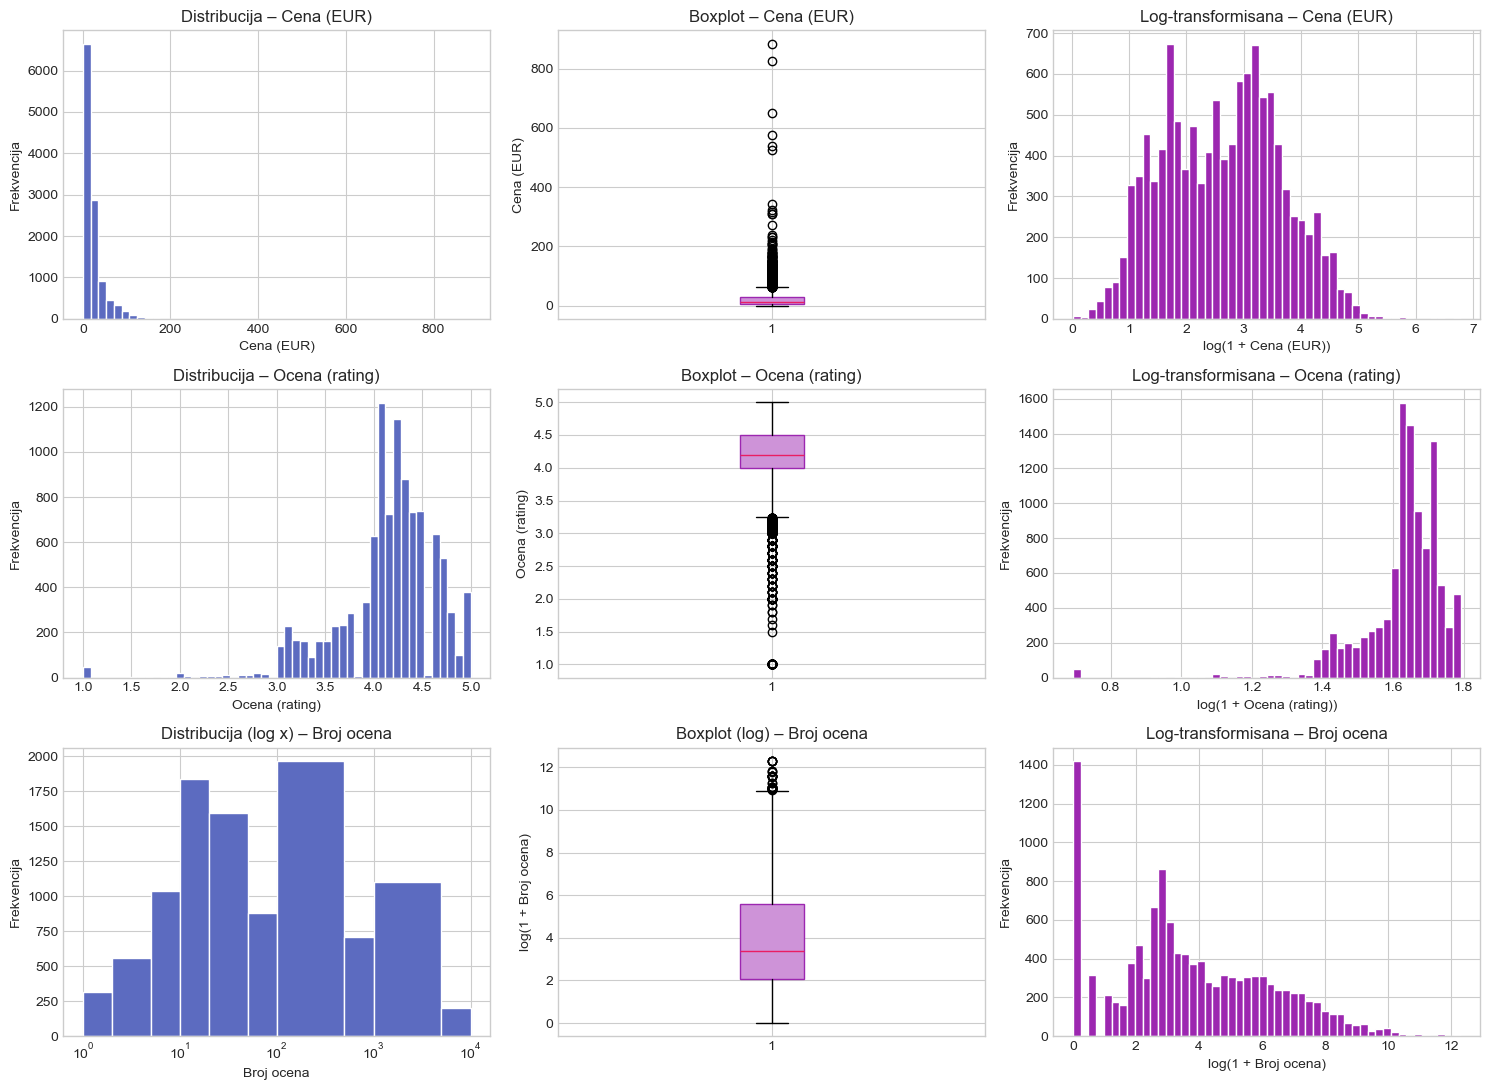


Statistički pregled numeričkih kolona:
              price        rating  noofratings
count  11580.000000  10391.000000      11808.0
mean      22.300573      4.137172   979.930894
std       29.939848      0.525300  6699.146129
min        0.015980      1.000000          0.0
25%        4.690600      4.000000          7.0
50%       13.823640      4.200000         28.5
75%       28.106000      4.500000        271.0
max      884.530600      5.000000     220040.0


In [218]:
fig, axes = plt.subplots(3, 3, figsize=(15, 11))

vars_config = [
    (dataset['price'].dropna(), 'Cena (EUR)'),
    (dataset['rating'].dropna(), 'Ocena (rating)'),
    (dataset['noofratings'].dropna(), 'Broj ocena'),
]

for row, (data, label) in enumerate(vars_config):

    if label == 'Broj ocena':
        bins = [1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000]
        axes[row, 0].hist(data, bins=bins, color=COLORS['blue'], edgecolor='white')
        axes[row, 0].set_xscale('log')
        axes[row, 0].set_title(f'Distribucija (log x) – {label}')
    else:
        axes[row, 0].hist(data, bins=50, color=COLORS['blue'], edgecolor='white')
        axes[row, 0].set_title(f'Distribucija – {label}')

    axes[row, 0].set_xlabel(label)
    axes[row, 0].set_ylabel('Frekvencija')

    if label == 'Broj ocena':
        bp = axes[row, 1].boxplot(
            np.log1p(data),
            vert=True,
            patch_artist=True
        )
        axes[row, 1].set_ylabel(f'log(1 + {label})')
        axes[row, 1].set_title(f'Boxplot (log) – {label}')
    else:
        bp = axes[row, 1].boxplot(
            data,
            vert=True,
            patch_artist=True
        )
        axes[row, 1].set_ylabel(label)
        axes[row, 1].set_title(f'Boxplot – {label}')

    bp['boxes'][0].set_facecolor(COLORS['purple_light'])
    bp['boxes'][0].set_edgecolor(COLORS['purple'])
    bp['medians'][0].set_color(COLORS['pink'])

    axes[row, 2].hist(
        np.log1p(data),
        bins=50,
        color=COLORS['purple'],
        edgecolor='white'
    )
    axes[row, 2].set_xlabel(f'log(1 + {label})')
    axes[row, 2].set_ylabel('Frekvencija')
    axes[row, 2].set_title(f'Log-transformisana – {label}')

plt.tight_layout()
plt.show()

print("\nStatistički pregled numeričkih kolona:")
print(dataset[['price', 'rating', 'noofratings']].describe())


### Analiza kategorijskih kolona

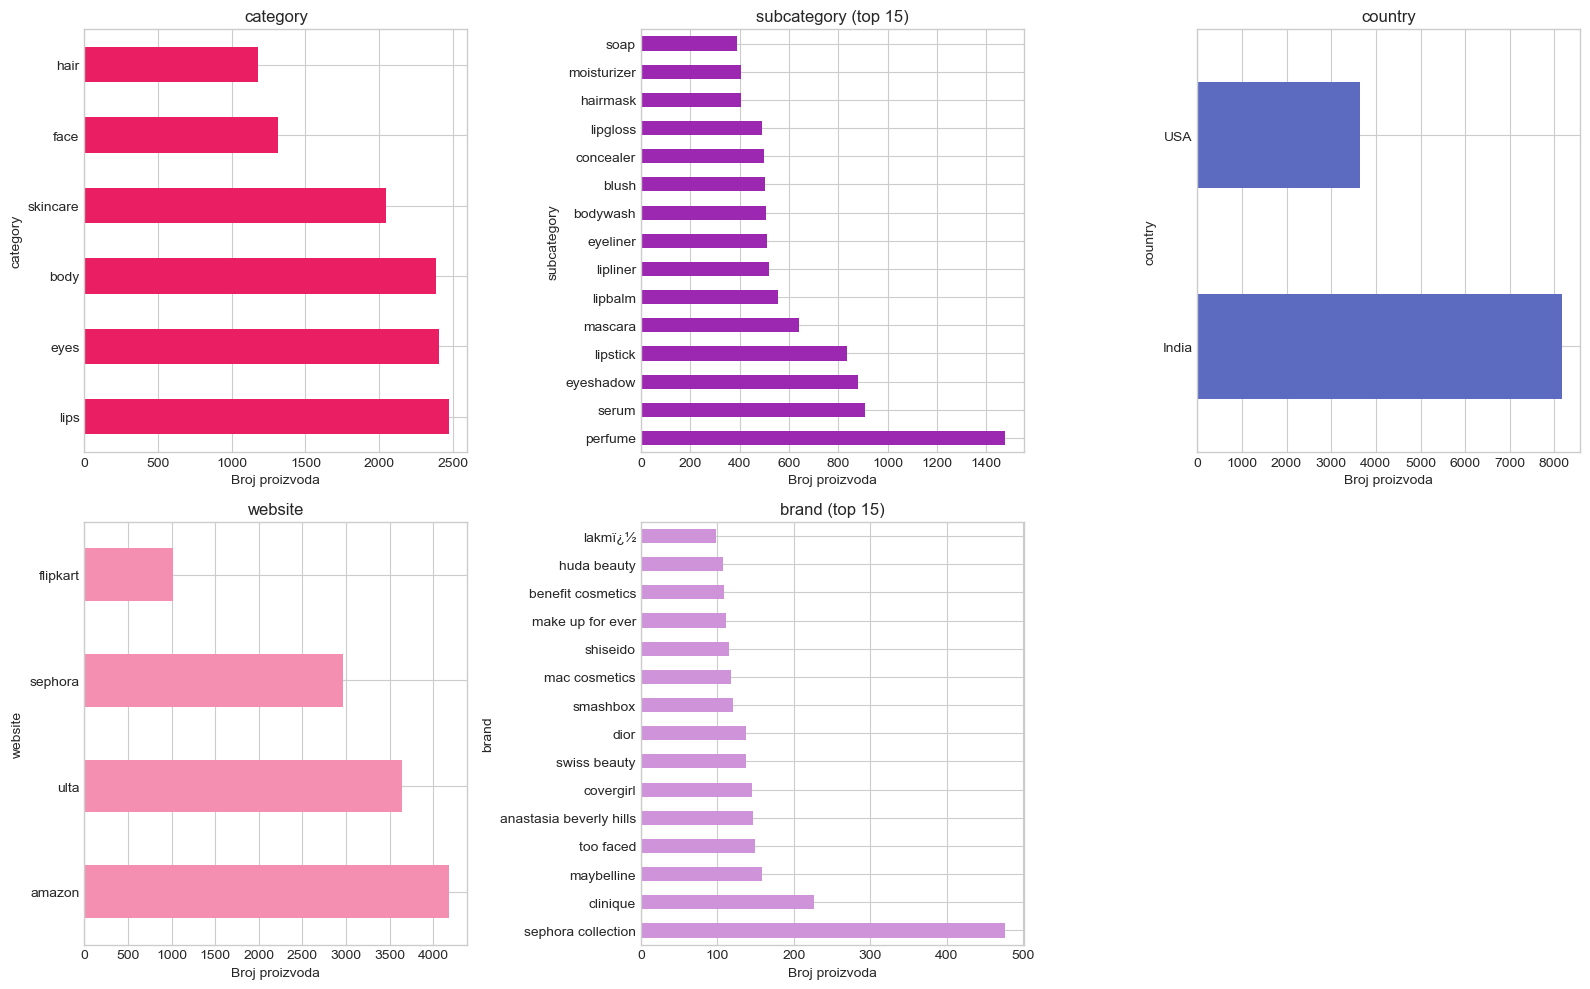

In [219]:
categorical_cols = ['category', 'subcategory', 'country', 'website', 'brand']

dataset['website'] = dataset['website'].str.lower()
dataset['brand'] = dataset['brand'].str.lower()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = dataset[col].value_counts()
    
    if len(value_counts) > 15:
        value_counts = value_counts.head(15)
        title = f'{col} (top 15)'
    else:
        title = col

    color = COLOR_PALETTE[idx % len(COLOR_PALETTE)]
    value_counts.plot(kind='barh', ax=axes[idx], color=color)
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Broj proizvoda')

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

### Veza između kolona Rating, Number of Ratings i Price

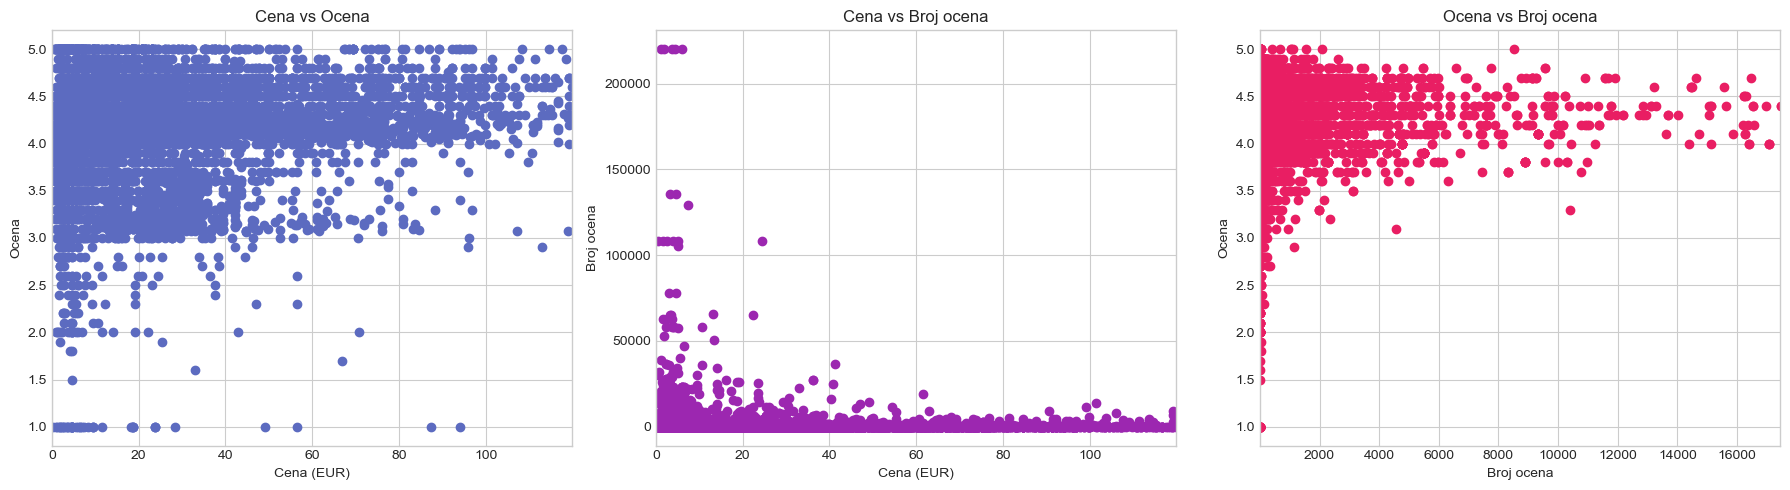

In [220]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(
    dataset['price'],
    dataset['rating'],
    c=COLORS['blue'],
)

axes[0].set_xlim(0, dataset['price'].quantile(0.99))
axes[0].set_xlabel('Cena (EUR)')
axes[0].set_ylabel('Ocena')
axes[0].set_title('Cena vs Ocena')

axes[1].scatter(
    dataset['price'],
    dataset['noofratings'],
    c=COLORS['purple'],
)

axes[1].set_xlim(0, dataset['price'].quantile(0.99))
axes[1].set_xlabel('Cena (EUR)')
axes[1].set_ylabel('Broj ocena')
axes[1].set_title('Cena vs Broj ocena')

axes[2].scatter(
    dataset['noofratings'],
    dataset['rating'],
    c=COLORS['pink'],
)

axes[2].set_xlim(0.1, dataset['noofratings'].quantile(0.99))
axes[2].set_xlabel('Broj ocena')
axes[2].set_ylabel('Ocena')
axes[2].set_title('Ocena vs Broj ocena')

plt.tight_layout()
plt.show()


In [221]:
print("Broj jedinstvenih vrednosti po kategorijskoh koloni:\n")
for col in categorical_cols:
    unique_count = dataset[col].nunique()
    print(f"{col}: {unique_count} jedinstvenih vrednosti")

Broj jedinstvenih vrednosti po kategorijskoh koloni:

category: 6 jedinstvenih vrednosti
subcategory: 36 jedinstvenih vrednosti
country: 2 jedinstvenih vrednosti
website: 4 jedinstvenih vrednosti
brand: 1555 jedinstvenih vrednosti


### Korelacione matrice

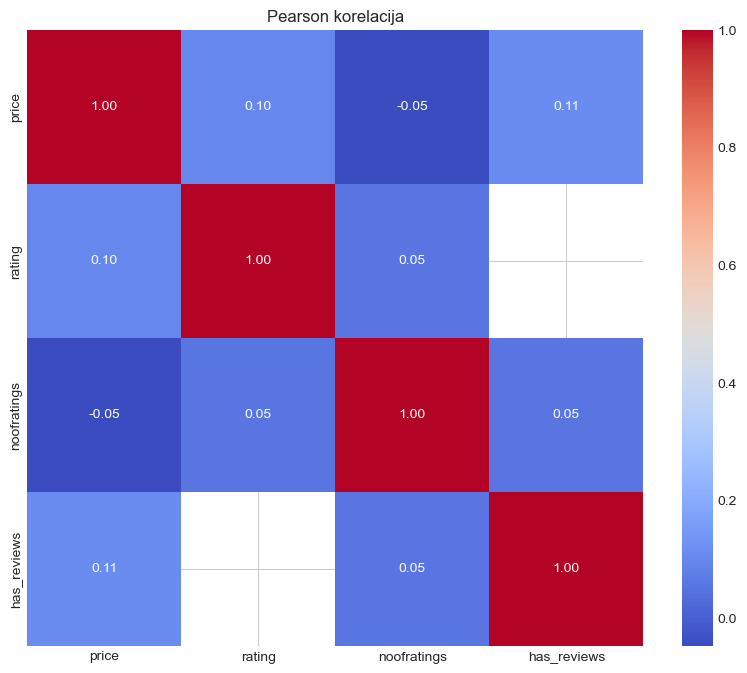

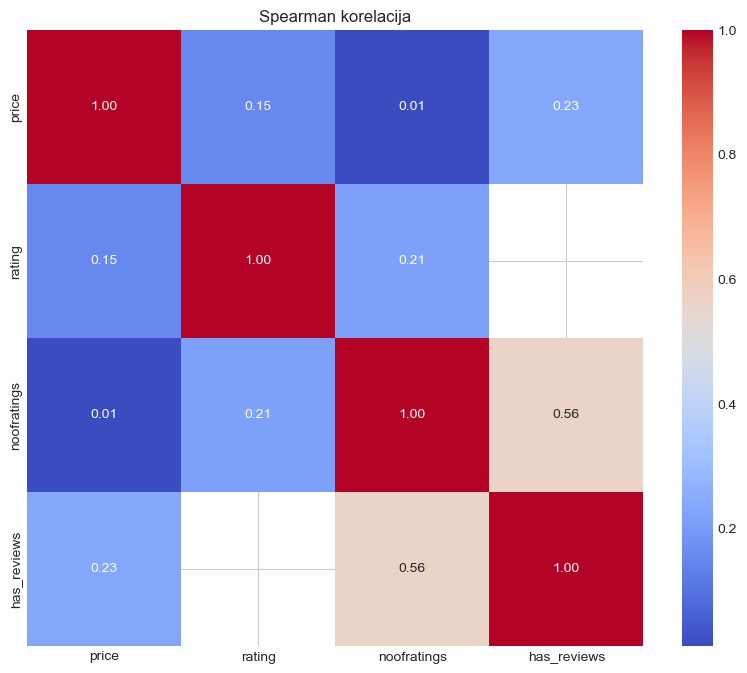

In [222]:
numeric_cols = dataset.select_dtypes(include='number').columns

pearson_corr = dataset[numeric_cols].corr(method='pearson')

spearman_corr = dataset[numeric_cols].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pearson korelacija")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Spearman korelacija")
plt.show()

### Prosečna ocena i prosečna cena po segmentima proizvoda

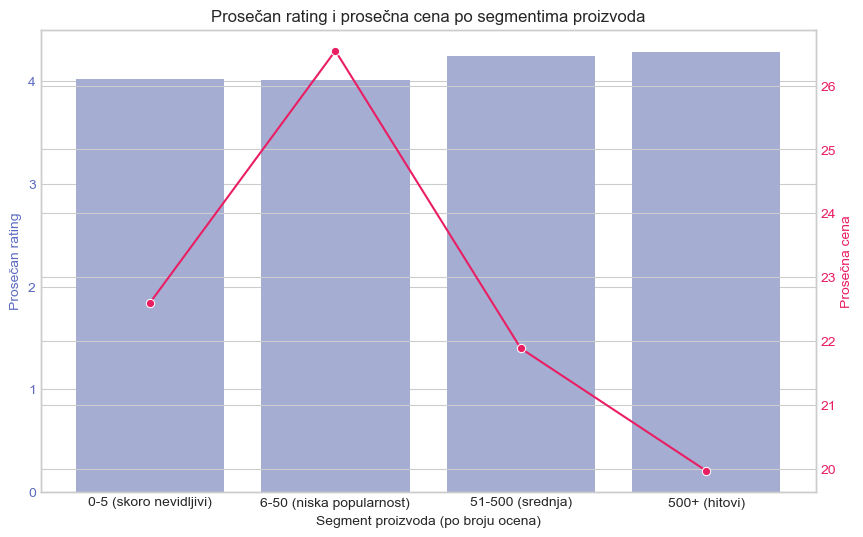

In [223]:
bins = [0, 5, 50, 500, float('inf')]
labels = ['0-5 (skoro nevidljivi)', '6-50 (niska popularnost)', '51-500 (srednja)', '500+ (hitovi)']
dataset['rating_bucket'] = pd.cut(dataset['noofratings'], bins=bins, labels=labels, right=True)

bucket_summary = dataset.groupby('rating_bucket').agg(
    avg_rating=('rating', 'mean'),
    avg_price=('price', 'mean'),
    count=('product_name', 'count')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(data=bucket_summary, x='rating_bucket', y='avg_rating', color=COLORS['blue_light'], ax=ax1)
ax1.set_ylabel('Prosečan rating', color=COLORS['blue'])
ax1.set_xlabel('Segment proizvoda (po broju ocena)')
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

ax2 = ax1.twinx()
sns.lineplot(data=bucket_summary, x='rating_bucket', y='avg_price', marker='o', color=COLORS['pink'], ax=ax2)
ax2.set_ylabel('Prosečna cena', color=COLORS['pink'])
ax2.tick_params(axis='y', labelcolor=COLORS['pink'])

plt.title('Prosečan rating i prosečna cena po segmentima proizvoda')
plt.show()


*Zapažanja* <br>
- Rating je stabilno visok u svim segmentima (oko 4.0–4.3)
- Blagi rast se vidi kod popularnijih proizvoda (51–500 i 500+), popularniji proizvodi imaju malo bolje ocene, ali razlika nije velika
- Najskuplji su proizvodi sa 6–50 ocena (niska popularnost)
- Kako popularnost raste, prosečna cena opada
- Hit proizvodi (500+) su najjeftiniji

### Obrada outlier-a

In [224]:
price_p01 = dataset['price'].quantile(0.01)
price_p99 = dataset['price'].quantile(0.99)

print(f"Price percentili:")
print(f"  1.  percentil: {price_p01:.2f} EUR")
print(f"  99. percentil: {price_p99:.2f} EUR")
print(f"  Redova pre cappinga iznad p99: {(dataset['price'] > price_p99).sum()}")
print(f"  Redova pre cappinga ispod p01: {(dataset['price'] < price_p01).sum()}")

dataset['price_winsorized'] = dataset['price'].clip(lower=price_p01, upper=price_p99)

print(f"\nStatistike price posle winsorizing-a:")
print(dataset['price_winsorized'].describe())

Price percentili:
  1.  percentil: 0.93 EUR
  99. percentil: 119.80 EUR
  Redova pre cappinga iznad p99: 115
  Redova pre cappinga ispod p01: 113

Statistike price posle winsorizing-a:
count    11580.000000
mean        21.665049
std         23.932572
min          0.930600
25%          4.690600
50%         13.823640
75%         28.106000
max        119.804880
Name: price_winsorized, dtype: float64


In [225]:
dataset['noofratings_log'] = np.log1p(dataset['noofratings'].astype(float))

print(f"noofratings log1p transformacija:")
print(dataset['noofratings_log'].describe())

noofratings log1p transformacija:
count    11808.000000
mean         3.782565
std          2.484407
min          0.000000
25%          2.079442
50%          3.384247
75%          5.605802
max         12.301569
Name: noofratings_log, dtype: float64


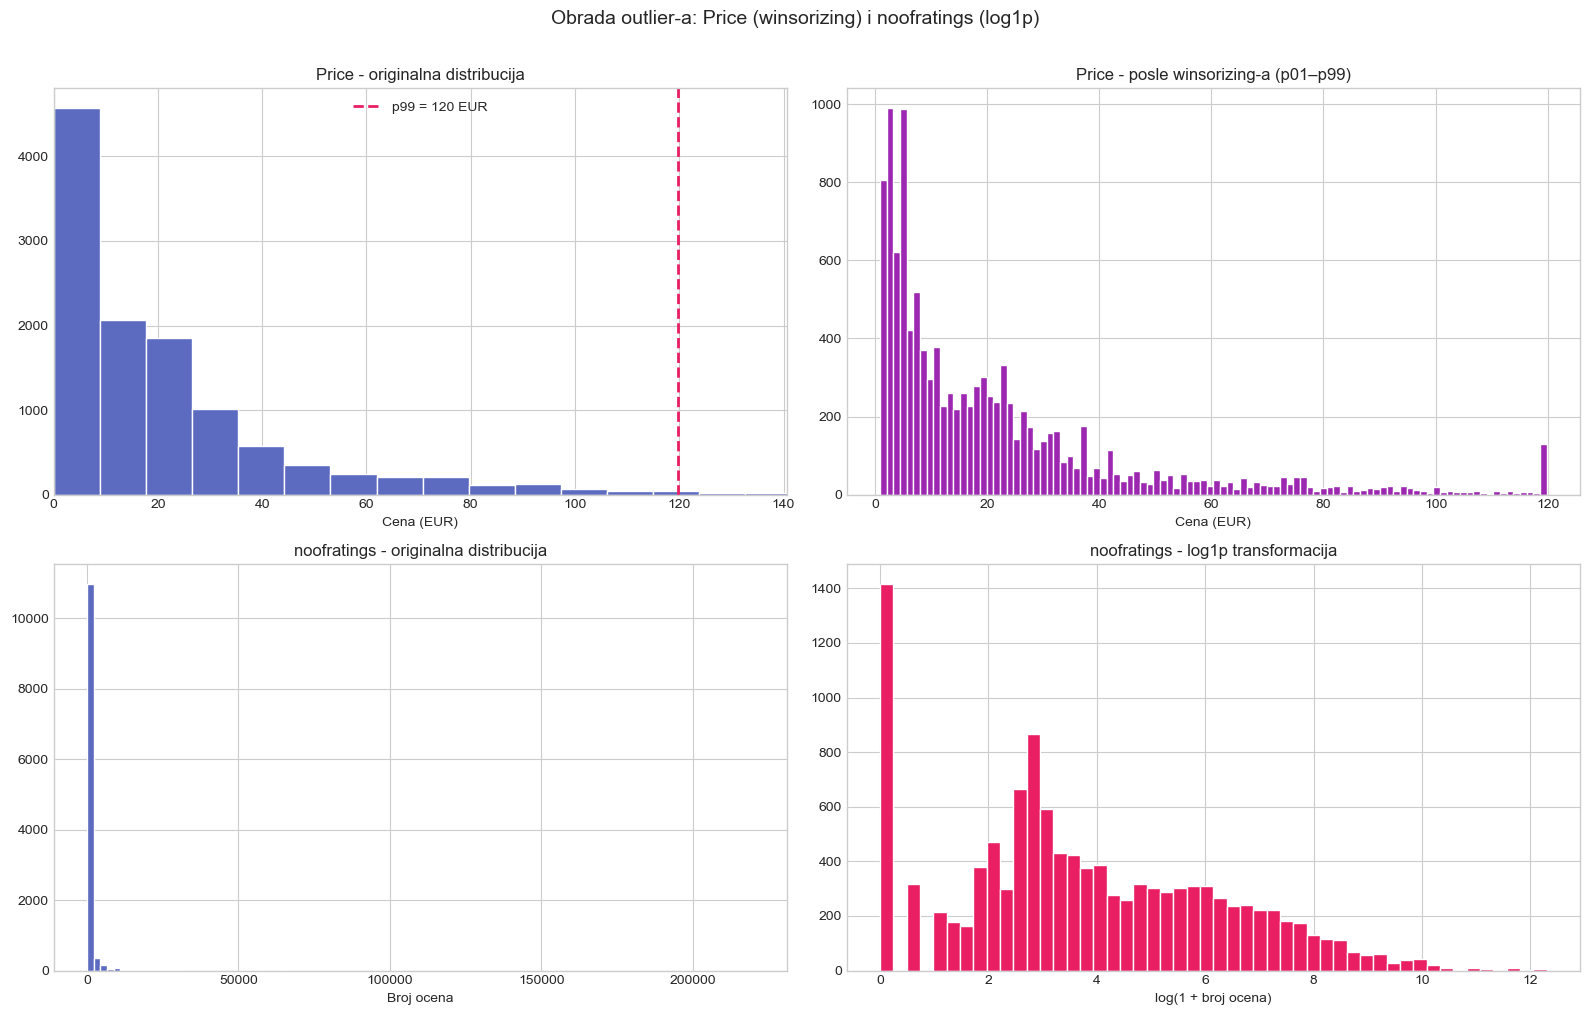

In [226]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
 
axes[0, 0].hist(dataset['price'].dropna(), bins=100, color=COLORS['blue'], edgecolor='white')
axes[0, 0].set_xlim(0, dataset['price'].quantile(0.995))
axes[0, 0].set_title('Price - originalna distribucija')
axes[0, 0].set_xlabel('Cena (EUR)')
axes[0, 0].axvline(price_p99, color=COLORS['pink'], linestyle='--', linewidth=2, label=f'p99 = {price_p99:.0f} EUR')
axes[0, 0].legend()

axes[0, 1].hist(dataset['price_winsorized'].dropna(), bins=100, color=COLORS['purple'], edgecolor='white')
axes[0, 1].set_title('Price - posle winsorizing-a (p01–p99)')
axes[0, 1].set_xlabel('Cena (EUR)')

axes[1, 0].hist(dataset['noofratings'].dropna().astype(float), bins=100, color=COLORS['blue'], edgecolor='white')
axes[1, 0].set_title('noofratings - originalna distribucija')
axes[1, 0].set_xlabel('Broj ocena')

axes[1, 1].hist(dataset['noofratings_log'].dropna(), bins=50, color=COLORS['pink'], edgecolor='white')
axes[1, 1].set_title('noofratings - log1p transformacija')
axes[1, 1].set_xlabel('log(1 + broj ocena)')

plt.suptitle('Obrada outlier-a: Price (winsorizing) i noofratings (log1p)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

In [227]:
summary = pd.DataFrame({
    'Kolona': ['price', 'price_winsorized', 'noofratings', 'noofratings_log'],
    'Min':  [dataset['price'].min(), dataset['price_winsorized'].min(),
             dataset['noofratings'].min(), dataset['noofratings_log'].min()],
    'Max':  [dataset['price'].max(), dataset['price_winsorized'].max(),
             dataset['noofratings'].max(), dataset['noofratings_log'].max()],
    'Mean': [dataset['price'].mean(), dataset['price_winsorized'].mean(),
             float(dataset['noofratings'].mean()), dataset['noofratings_log'].mean()],
    'Std':  [dataset['price'].std(), dataset['price_winsorized'].std(),
             float(dataset['noofratings'].std()), dataset['noofratings_log'].std()],
}).round(3)

display(summary)

,Kolona,Min,Max,Mean,Std
0,price,0.016,884.531,22.301,29.940
1,price_winsorized,0.931,119.805,21.665,23.933
2,noofratings,0.000,220040.000,979.931,6699.146
3,noofratings_log,0.000,12.302,3.783,2.484


### Korekcija ocene — Bayesian Average

Distribucija ratinga je stisnuta između 3.2 i 4.6, što otežava razlikovanje klastera po kvalitetu.

**Problem:** Proizvod sa rating 4.8 i 2 ocene vs proizvod sa rating 4.2 i 3000 ocena — K-Means ih tretira skoro jednako po rating dimenziji.

**Rešenje — Bayesian Average:**
```
bayesian_rating = (n × rating + m × C) / (n + m)
```
- `n` = broj ocena proizvoda  
- `C` = globalni prosek svih ocena (prior)  
- `m` = težina priora — medijana broja ocena (koliko ocena je potrebno da ocena bude "pouzdana")

Proizvodi sa malo ocena se "povlače" prema globalnom proseku, dok proizvodi sa mnogo ocena zadržavaju svoju stvarnu ocenu.

### Korekcija ocene — Bayesian Average

Distribucija ratinga je stisnuta između 3.2 i 4.6, što otežava razlikovanje klastera po kvalitetu.

**Problem:** Proizvod sa rating 4.8 i 2 ocene vs proizvod sa rating 4.2 i 3000 ocena — K-Means ih tretira skoro jednako po rating dimenziji.

**Rešenje — Bayesian Average:**
```
bayesian_rating = (n × rating + m × C) / (n + m)
```
- `n` = broj ocena proizvoda  
- `C` = globalni prosek svih ocena (prior)  
- `m` = težina priora — medijana broja ocena (koliko ocena je potrebno da ocena bude "pouzdana")

Proizvodi sa malo ocena se "povlače" prema globalnom proseku, dok proizvodi sa mnogo ocena zadržavaju svoju stvarnu ocenu.

Globalni prosek ocena (C): 4.1372
Težina priora - m (medijana broja ocena): 45.0

Poređenje rating vs bayesian_rating:
           rating  bayesian_rating  noofratings
count  10391.0000       10391.0000      11808.0
mean       4.1372           4.1790     979.9309
std        0.5253           0.2360    6699.1461
min        1.0000           2.7175          0.0
25%        4.0000           4.0837          7.0
50%        4.2000           4.1559         28.5
75%        4.5000           4.2970        271.0
max        5.0000           4.9955     220040.0


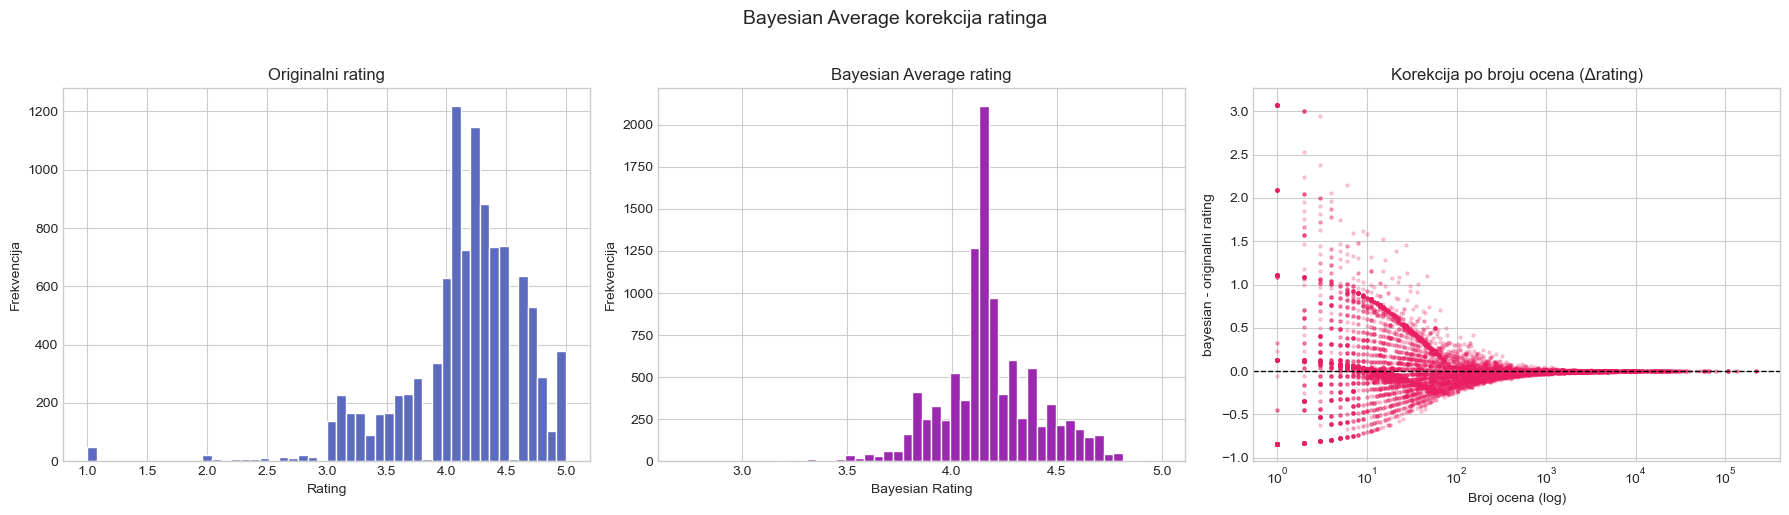


Primeri korekcije — mali broj ocena (povlačenje prema proseku):


,product_name,rating,bayesian_rating,noofratings
18,Natural Dead Sea Bath Salts,4.0,4.134,1
61,Aromarama Sandalwood Shower Steamer,3.0,4.112,1
62,Aromarama Lavender Shower Steamer,5.0,4.174,2
63,Aromarama Eucalyptus Shower Steamer,4.0,4.134,1
67,Bath Fizzers Flower Bath Bomb,4.5,4.153,2
70,Mandalorian The Child Bath Bomb,5.0,4.174,2
71,Beach Bath Bomb,5.0,4.156,1
73,Barbie Pink Swirl Bath Bomb,5.0,4.174,2



Primeri korekcije — veliki broj ocena (ocena ostaje stabilna):


,product_name,rating,bayesian_rating,noofratings
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,4.4,4.397,4031
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,4.4,4.397,4072
5,"Engage Fantasia Perfume for Women, Long Lastin...",4.4,4.399,13101
7,"Engage One Soul Gender-free Perfume, Unisex, L...",4.5,4.498,9665
11,ENVY Blush Women Perfume - 60 | Long Lasting L...,4.3,4.298,4349
38,Pure Goat Milk Body Bar Soap,4.9,4.878,1489
109,Soothe & Sleep with Lavender Pure Epsom Salt S...,4.8,4.785,1987
110,Eucalyptus Epsom Salt Relax,4.8,4.785,1987


In [228]:
C = dataset[dataset['noofratings'] > 0]['rating'].mean()
m = dataset[dataset['noofratings'] > 0]['noofratings'].quantile(0.50)

print(f"Globalni prosek ocena (C): {C:.4f}")
print(f"Težina priora - m (medijana broja ocena): {m:.1f}")

def bayesian_average(row):
    n = row['noofratings']
    r = row['rating']
    if pd.isna(n) or pd.isna(r) or n == 0:
        return np.nan
    return (n * r + m * C) / (n + m)

dataset['bayesian_rating'] = dataset.apply(bayesian_average, axis=1)

print(f"\nPoređenje rating vs bayesian_rating:")
print(dataset[['rating', 'bayesian_rating', 'noofratings']].describe().round(4))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(dataset['rating'].dropna(), bins=50, color=COLORS['blue'], edgecolor='white')
axes[0].set_title('Originalni rating')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frekvencija')

axes[1].hist(dataset['bayesian_rating'].dropna(), bins=50, color=COLORS['purple'], edgecolor='white')
axes[1].set_title('Bayesian Average rating')
axes[1].set_xlabel('Bayesian Rating')
axes[1].set_ylabel('Frekvencija')

axes[2].scatter(
    dataset['noofratings'].astype(float),
    dataset['bayesian_rating'] - dataset['rating'],
    alpha=0.2, s=5, color=COLORS['pink']
)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_xscale('log')
axes[2].set_title('Korekcija po broju ocena (Δrating)')
axes[2].set_xlabel('Broj ocena (log)')
axes[2].set_ylabel('bayesian - originalni rating')

plt.suptitle('Bayesian Average korekcija ratinga', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nPrimeri korekcije — mali broj ocena (povlačenje prema proseku):")
sample_mali = dataset[dataset['noofratings'] < 5][
    ['product_name', 'rating', 'bayesian_rating', 'noofratings']
].dropna().head(8)
display(sample_mali.round(3))

print("\nPrimeri korekcije — veliki broj ocena (ocena ostaje stabilna):")
sample_veliki = dataset[dataset['noofratings'] > 1000][
    ['product_name', 'rating', 'bayesian_rating', 'noofratings']
].dropna().head(8)
display(sample_veliki.round(3))


## Klasterizacija

### Priprema feature seta

Feature-i za klasterizaciju: `price_winsorized`, `bayesian_rating`, `noofratings_log`, `has_reviews`.

Koristimo `bayesian_rating` umesto originalnog `rating` — koriguje nepouzdane ocene proizvoda sa malim brojem recenzija.

Neocenjeni proizvodi dobijaju `bayesian_rating=0`, cena se imputuje medijanom po subcategory.

In [229]:
CLUSTERING_FEATURES = ['price_winsorized', 'bayesian_rating', 'noofratings_log', 'has_reviews']

df_cluster = dataset[CLUSTERING_FEATURES + ['product_name', 'category', 'subcategory', 'brand']].copy()

n_before = len(df_cluster)

df_cluster['price_winsorized'] = df_cluster.groupby('subcategory')['price_winsorized']     .transform(lambda x: x.fillna(x.median()))

global_price_median = df_cluster['price_winsorized'].median()
df_cluster['price_winsorized'] = df_cluster['price_winsorized'].fillna(global_price_median)

df_cluster = df_cluster.dropna(subset=CLUSTERING_FEATURES)
n_after = len(df_cluster)

print(f"Redova pre obrade: {n_before}")
print(f"Redova posle obrade: {n_after}")
print(f"Uklonjeno (edge case null-ovi): {n_before - n_after} redova ({(n_before - n_after) / n_before * 100:.1f}%)")
print(f"\nNull vrednosti po feature-ima:")
print(df_cluster[CLUSTERING_FEATURES].isnull().sum())
print(f"\nBroj proizvoda sa has_reviews=0: {(df_cluster['has_reviews'] == 0).sum()}")
print(f"\nFeature-i za klasterizaciju: {CLUSTERING_FEATURES}")
print(f"\nPregled:")
display(df_cluster[CLUSTERING_FEATURES].describe())


Redova pre obrade: 11808
Redova posle obrade: 10391
Uklonjeno (edge case null-ovi): 1417 redova (12.0%)

Null vrednosti po feature-ima:
price_winsorized    0
bayesian_rating     0
noofratings_log     0
has_reviews         0
dtype: int64

Broj proizvoda sa has_reviews=0: 0

Feature-i za klasterizaciju: ['price_winsorized', 'bayesian_rating', 'noofratings_log', 'has_reviews']

Pregled:


,price_winsorized,bayesian_rating,noofratings_log,has_reviews
count,10391.000000,10391.000000,10391.000000,10391.0
mean,22.715130,4.178990,4.298385,1.0
std,23.878276,0.235973,2.190126,0.0
min,0.930600,2.717539,0.693147,1.0
25%,5.635300,4.083733,2.639057,1.0
50%,15.359600,4.155929,3.828641,1.0
75%,29.506600,4.296952,5.888878,1.0
max,119.804880,4.995474,12.301569,1.0


### Razdvajanje ocenjenih i neocenjenih proizvoda

Neocenjeni proizvodi (has_reviews=0) dominiraju klasterizacijom kao zaseban signal. Tretiramo ih kao unapred definisanu grupu i klasterišemo samo ocenjene proizvode.

In [230]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

df_rated = df_cluster[df_cluster['has_reviews'] == 1].copy()
df_unrated = df_cluster[df_cluster['has_reviews'] == 0].copy()

print(f"Ocenjeni proizvodi (za klasterizaciju): {len(df_rated)}")
print(f"Neocenjeni proizvodi (unapred definisana grupa): {len(df_unrated)}")

CLUSTERING_FEATURES_V3 = ['price_winsorized', 'bayesian_rating', 'noofratings_log']

scaler_v3 = RobustScaler()
X_scaled_v3 = scaler_v3.fit_transform(df_rated[CLUSTERING_FEATURES_V3])
X_scaled_v3 = pd.DataFrame(X_scaled_v3, columns=CLUSTERING_FEATURES_V3, index=df_rated.index)

print(f"\nStatistike skaliranih feature-a (samo ocenjeni):")
display(X_scaled_v3.describe().round(3))


Ocenjeni proizvodi (za klasterizaciju): 10391
Neocenjeni proizvodi (unapred definisana grupa): 0

Statistike skaliranih feature-a (samo ocenjeni):


,price_winsorized,bayesian_rating,noofratings_log
count,10391.000,10391.000,10391.000
mean,0.308,0.108,0.145
std,1.000,1.107,0.674
min,-0.604,-6.746,-0.965
25%,-0.407,-0.339,-0.366
50%,0.000,0.000,0.000
75%,0.593,0.661,0.634
max,4.375,3.937,2.607


### Određivanje optimalnog broja klastera

Koristimo Elbow metod, Silhouette score, Davies-Bouldin i Calinski-Harabasz indeks — samo na ocenjenim proizvodima.

In [231]:
K_RANGE = range(2, 11)

inertia_v3 = []
silhouette_scores_v3 = []
davies_bouldin_scores_v3 = []
calinski_harabasz_scores_v3 = []

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_v3)
    
    inertia_v3.append(kmeans.inertia_)
    silhouette_scores_v3.append(silhouette_score(X_scaled_v3, labels))
    davies_bouldin_scores_v3.append(davies_bouldin_score(X_scaled_v3, labels))
    calinski_harabasz_scores_v3.append(calinski_harabasz_score(X_scaled_v3, labels))
    
    print(f"k={k:2d} | Inertia: {kmeans.inertia_:10.1f} | Silhouette: {silhouette_score(X_scaled_v3, labels):.4f} | Davies-Bouldin: {davies_bouldin_score(X_scaled_v3, labels):.4f}")

k= 2 | Inertia:    18921.1 | Silhouette: 0.3661 | Davies-Bouldin: 1.2854
k= 3 | Inertia:    13123.7 | Silhouette: 0.3806 | Davies-Bouldin: 0.9414
k= 4 | Inertia:    10031.2 | Silhouette: 0.3642 | Davies-Bouldin: 0.9810
k= 5 | Inertia:     8515.9 | Silhouette: 0.3546 | Davies-Bouldin: 0.9146
k= 6 | Inertia:     7400.5 | Silhouette: 0.3619 | Davies-Bouldin: 0.9497
k= 7 | Inertia:     6550.1 | Silhouette: 0.3498 | Davies-Bouldin: 0.9004
k= 8 | Inertia:     5891.7 | Silhouette: 0.3611 | Davies-Bouldin: 0.9102
k= 9 | Inertia:     5271.0 | Silhouette: 0.3505 | Davies-Bouldin: 0.9787
k=10 | Inertia:     4871.2 | Silhouette: 0.3516 | Davies-Bouldin: 0.9324


### DBSCAN

DBSCAN (Density-Based Spatial Clustering) grupiše tačke na osnovu gustine prostora, ne zahteva unapred definisan broj klastera i može da identifikuje outliere kao šum.

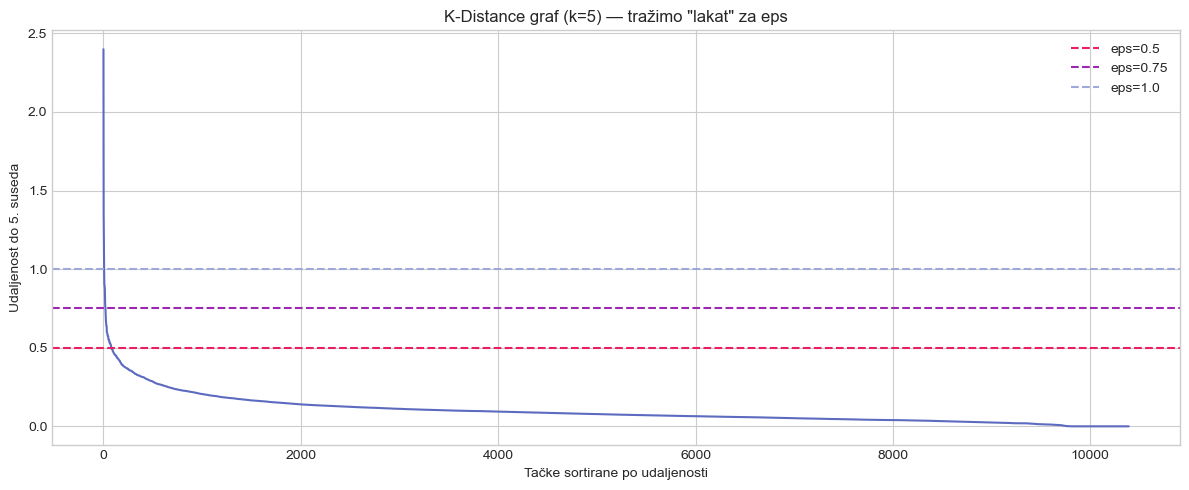

In [232]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

k_neighbors = 5 
nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_scaled_v3)
distances, _ = nbrs.kneighbors(X_scaled_v3)

k_distances = np.sort(distances[:, -1])[::-1]

plt.figure(figsize=(12, 5))
plt.plot(k_distances, color=COLORS['blue'], linewidth=1.5)
plt.axhline(y=0.5, color=COLORS['pink'], linestyle='--', linewidth=1.5, label='eps=0.5')
plt.axhline(y=0.75, color=COLORS['purple'], linestyle='--', linewidth=1.5, label='eps=0.75')
plt.axhline(y=1.0, color=COLORS['blue_light'], linestyle='--', linewidth=1.5, label='eps=1.0')
plt.title('K-Distance graf (k=5) — tražimo "lakat" za eps')
plt.xlabel('Tačke sortirane po udaljenosti')
plt.ylabel(f'Udaljenost do {k_neighbors}. suseda')
plt.legend()
plt.tight_layout()
plt.show()

In [233]:
dbscan_params = [
    (0.5,  5),
    (0.5, 10),
    (0.75, 5),
    (0.75, 10),
    (1.0,  5),
    (1.0, 10),
]

print(f"{'eps':>6} {'min_s':>6} {'n_klastera':>11} {'n_noise':>8} {'noise_%':>8} {'silhouette':>11}")
print("-" * 58)

dbscan_rezultati = []
for eps, min_samples in dbscan_params:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled_v3)
    
    n_klastera = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_pct = n_noise / len(labels) * 100
    
    sil = silhouette_score(X_scaled_v3, labels) if n_klastera > 1 and n_noise < len(labels) * 0.9 else None
    sil_str = f"{sil:.4f}" if sil else "N/A"
    
    dbscan_rezultati.append({
        'eps': eps, 'min_samples': min_samples,
        'n_klastera': n_klastera, 'n_noise': n_noise,
        'noise_pct': round(noise_pct, 1), 'silhouette': sil
    })
    
    print(f"{eps:>6} {min_samples:>6} {n_klastera:>11} {n_noise:>8} {noise_pct:>7.1f}% {sil_str:>11}")

dbscan_df = pd.DataFrame(dbscan_rezultati)

   eps  min_s  n_klastera  n_noise  noise_%  silhouette
----------------------------------------------------------
   0.5      5           1       37     0.4%         N/A
   0.5     10           1       73     0.7%         N/A
  0.75      5           1        8     0.1%         N/A
  0.75     10           1       14     0.1%         N/A
   1.0      5           1        3     0.0%         N/A
   1.0     10           1        6     0.1%         N/A


In [234]:
db_final = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = db_final.fit_predict(X_scaled_v3)

df_rated['klaster_dbscan'] = dbscan_labels
df_unrated['klaster_dbscan'] = -99  # posebna oznaka za neocenjene

df_final_dbscan = pd.concat([df_rated, df_unrated]).sort_index()

dbscan_labele_map = {-1: 'Noise/Outlieri', -99: 'Novi/Neocenjeni'}
for k in sorted(set(dbscan_labels)):
    if k >= 0:
        dbscan_labele_map[k] = f'DBSCAN Klaster {k}'

df_final_dbscan['klaster_naziv_dbscan'] = df_final_dbscan['klaster_dbscan'].map(dbscan_labele_map)

print("Raspodela DBSCAN klastera:")
display(df_final_dbscan.groupby(['klaster_dbscan', 'klaster_naziv_dbscan']).size()
        .reset_index(name='n_proizvoda')
        .assign(procenat=lambda x: (x['n_proizvoda'] / len(df_final_dbscan) * 100).round(1)))

Raspodela DBSCAN klastera:


,klaster_dbscan,klaster_naziv_dbscan,n_proizvoda,procenat
0,-1,Noise/Outlieri,37,0.4
1,0,DBSCAN Klaster 0,10354,99.6


In [235]:
profil_dbscan = df_final_dbscan.groupby('klaster_naziv_dbscan').agg(
    n_proizvoda=('price_winsorized', 'count'),
    avg_cena=('price_winsorized', 'mean'),
    median_cena=('price_winsorized', 'median'),
    avg_rating=('bayesian_rating', 'mean'),
    median_noofratings=('noofratings_log', lambda x: round(np.expm1(x.median())))
).round(2)

print("Profil DBSCAN klastera:")
display(profil_dbscan)

Profil DBSCAN klastera:


,n_proizvoda,avg_cena,median_cena,avg_rating,median_noofratings
klaster_naziv_dbscan,,,,,
DBSCAN Klaster 0,10354,22.61,15.36,4.18,45
Noise/Outlieri,37,52.34,46.99,3.71,597


### Hierarchical (Agglomerative) Clustering

Agglomerativno klasterovanje gradi hijerarhiju klastera odozdo prema gore koristeći Ward metod koji minimizuje varijansu unutar klastera.

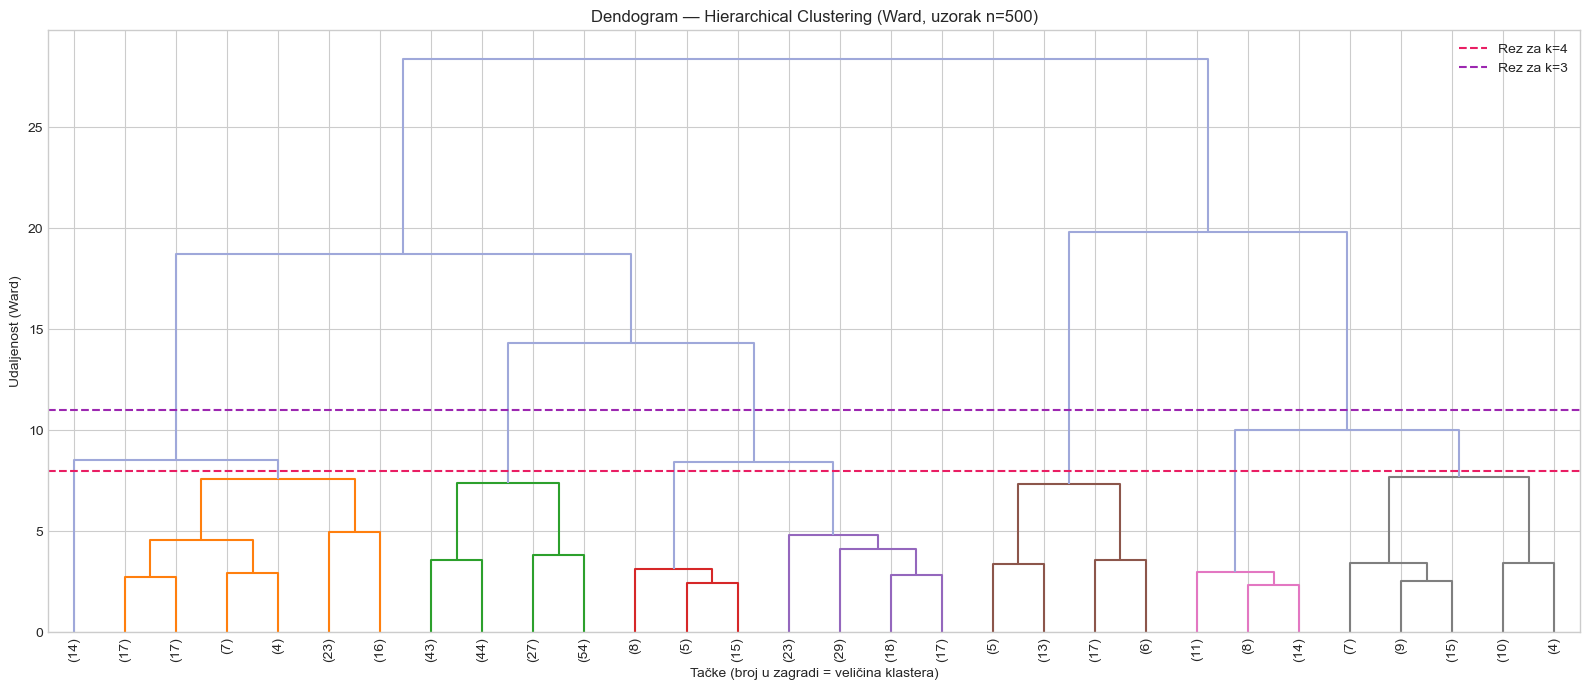

In [236]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled_v3), size=500, replace=False)
X_sample = X_scaled_v3.iloc[sample_idx]

linked = linkage(X_sample, method='ward')

plt.figure(figsize=(16, 7))
dendrogram(
    linked,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=8,
    above_threshold_color=COLORS['blue_light']
)
plt.title('Dendogram — Hierarchical Clustering (Ward, uzorak n=500)')
plt.xlabel('Tačke (broj u zagradi = veličina klastera)')
plt.ylabel('Udaljenost (Ward)')
plt.axhline(y=8, color=COLORS['pink'], linestyle='--', linewidth=1.5, label='Rez za k=4')
plt.axhline(y=11, color=COLORS['purple'], linestyle='--', linewidth=1.5, label='Rez za k=3')
plt.legend()
plt.tight_layout()
plt.show()

In [237]:
from sklearn.cluster import AgglomerativeClustering

agg_k3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_k4 = AgglomerativeClustering(n_clusters=4, linkage='ward')

df_rated['klaster_agg_k3'] = agg_k3.fit_predict(X_scaled_v3)
df_rated['klaster_agg_k4'] = agg_k4.fit_predict(X_scaled_v3)

print("Raspodela Agglomerative k=3:")
print(pd.Series(df_rated['klaster_agg_k3']).value_counts().sort_index())

print("\nRaspodela Agglomerative k=4:")
print(pd.Series(df_rated['klaster_agg_k4']).value_counts().sort_index())

Raspodela Agglomerative k=3:
klaster_agg_k3
0    7553
1    1417
2    1421
Name: count, dtype: int64

Raspodela Agglomerative k=4:
klaster_agg_k4
0    5919
1    1417
2    1421
3    1634
Name: count, dtype: int64


In [238]:
df_rated['klaster_agg_k4'] = agg_k4.fit_predict(X_scaled_v3)

kmeans_k4_comp = KMeans(n_clusters=4, random_state=42, n_init=10)
df_rated['klaster_k4'] = kmeans_k4_comp.fit_predict(X_scaled_v3)

profil_agg = df_rated.groupby('klaster_agg_k4').agg(
    n_proizvoda=('price_winsorized', 'count'),
    avg_cena=('price_winsorized', 'mean'),
    median_cena=('price_winsorized', 'median'),
    avg_rating=('bayesian_rating', 'mean'),
    median_noofratings=('noofratings_log', lambda x: round(np.expm1(x.median())))
).round(2)

print("Profil Agglomerative klastera (k=4):")
display(profil_agg)

print("\nCrosstab: Agglomerative k=4 vs K-Means k=4:")
display(pd.crosstab(
    df_rated['klaster_agg_k4'],
    df_rated['klaster_k4'],
    margins=True
))


Profil Agglomerative klastera (k=4):


,n_proizvoda,avg_cena,median_cena,avg_rating,median_noofratings
klaster_agg_k4,,,,,
0,5919,12.78,9.22,4.17,24
1,1417,72.23,68.43,4.26,25
2,1421,20.39,18.44,4.54,375
3,1634,17.80,16.92,3.83,43



Crosstab: Agglomerative k=4 vs K-Means k=4:


klaster_k4,0,1,2,3,All
klaster_agg_k4,,,,,
0,627,4319,964,9,5919
1,21,157,94,1145,1417
2,0,3,1418,0,1421
3,1354,280,0,0,1634
All,2002,4759,2476,1154,10391


### Evaluacija sva tri algoritma

Poredimo K-Means, DBSCAN i Agglomerative Clustering po Silhouette, Davies-Bouldin i Calinski-Harabasz metrikama.

In [239]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

rezultati_eval = []

for naziv, labele in [
    ('K-Means k=4',        df_rated['klaster_k4']),
    ('DBSCAN eps=0.5',     df_rated['klaster_dbscan']),
    ('Agglomerative k=4',  df_rated['klaster_agg_k4']),
]:
    mask = labele != -1
    X_eval = X_scaled_v3[mask]
    l_eval = labele[mask]
    
    if l_eval.nunique() < 2:
        continue

    rezultati_eval.append({
        'Algoritam': naziv,
        'n_klastera': l_eval.nunique(),
        'Silhouette ↑': round(silhouette_score(X_eval, l_eval), 4),
        'Davies-Bouldin ↓': round(davies_bouldin_score(X_eval, l_eval), 4),
        'Calinski-Harabasz ↑': round(calinski_harabasz_score(X_eval, l_eval), 1),
    })

eval_df = pd.DataFrame(rezultati_eval)
print("Evaluacija algoritama:")
display(eval_df)

Evaluacija algoritama:


,Algoritam,n_klastera,Silhouette ↑,Davies-Bouldin ↓,Calinski-Harabasz ↑
0,K-Means k=4,4,0.3642,0.9810,6147.2
1,Agglomerative k=4,4,0.3043,1.0081,4931.8


## Feature Engineering

Dodajemo nove feature-e koji kombinuju postojeće signale:
-  — koliko košta jedinica kvaliteta
-  — kombinuje rating i popularnost

In [240]:
df_rated['price_per_rating'] = df_rated['price_winsorized'] / df_rated['bayesian_rating']
df_rated['popularity_score'] = df_rated['bayesian_rating'] * df_rated['noofratings_log']

print("Novi feature-i:")
display(df_rated[['price_winsorized', 'bayesian_rating', 'noofratings_log',
                   'price_per_rating', 'popularity_score']].describe().round(3))


Novi feature-i:


,price_winsorized,bayesian_rating,noofratings_log,price_per_rating,popularity_score
count,10391.000,10391.000,10391.000,10391.000,10391.000
mean,22.715,4.179,4.298,5.396,18.112
std,23.878,0.236,2.190,5.608,9.624
min,0.931,2.718,0.693,0.195,2.820
25%,5.635,4.084,2.639,1.376,10.729
50%,15.360,4.156,3.829,3.643,15.570
75%,29.507,4.297,5.889,7.124,25.198
max,119.805,4.995,12.302,34.709,55.356


In [241]:
CLUSTERING_FEATURES_ENG = ['price_winsorized', 'bayesian_rating', 'noofratings_log',
                            'price_per_rating', 'popularity_score']

scaler_eng = RobustScaler()
X_scaled_eng = scaler_eng.fit_transform(df_rated[CLUSTERING_FEATURES_ENG])
X_scaled_eng = pd.DataFrame(X_scaled_eng, columns=CLUSTERING_FEATURES_ENG, index=df_rated.index)

print("Skaliranje završeno.")
print(f"\nStatistike:")
display(X_scaled_eng.describe().round(3))


Skaliranje završeno.

Statistike:


,price_winsorized,bayesian_rating,noofratings_log,price_per_rating,popularity_score
count,10391.000,10391.000,10391.000,10391.000,10391.000
mean,0.308,0.108,0.145,0.305,0.176
std,1.000,1.107,0.674,0.976,0.665
min,-0.604,-6.746,-0.965,-0.600,-0.881
25%,-0.407,-0.339,-0.366,-0.394,-0.335
50%,0.000,0.000,0.000,0.000,0.000
75%,0.593,0.661,0.634,0.606,0.665
max,4.375,3.937,2.607,5.405,2.750


In [242]:
print("K-Means sa engineered feature-ima:")
print(f"{'k':>4} | {'Inertia':>12} | {'Silhouette':>11} | {'Davies-Bouldin':>15} | {'Calinski-Harabasz':>18}")
print("-" * 70)

inertia_eng, sil_eng, db_eng, ch_eng = [], [], [], []

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_eng)
    
    inertia_eng.append(km.inertia_)
    sil_eng.append(silhouette_score(X_scaled_eng, labels))
    db_eng.append(davies_bouldin_score(X_scaled_eng, labels))
    ch_eng.append(calinski_harabasz_score(X_scaled_eng, labels))
    
    print(f"{k:>4} | {km.inertia_:>12.1f} | {sil_eng[-1]:>11.4f} | {db_eng[-1]:>15.4f} | {ch_eng[-1]:>18.1f}")

K-Means sa engineered feature-ima:
   k |      Inertia |  Silhouette |  Davies-Bouldin |  Calinski-Harabasz
----------------------------------------------------------------------
   2 |      28075.8 |      0.4556 |          0.9671 |             5273.9
   3 |      19067.6 |      0.3666 |          0.9892 |             6336.2
   4 |      15420.2 |      0.3483 |          1.0251 |             6041.7
   5 |      13069.1 |      0.3355 |          0.9553 |             5813.0
   6 |      11333.8 |      0.3347 |          0.9821 |             5680.0
   7 |      10040.7 |      0.3383 |          1.0010 |             5565.2
   8 |       9174.9 |      0.3477 |          0.9606 |             5359.9


In [243]:
print("K-Means k=5 i k=6 — originalni feature-i:")
print(f"{'k':>4} | {'Silhouette':>11} | {'Davies-Bouldin':>15} | {'Calinski-Harabasz':>18} | {'n_klastera_smislenih':>20}")
print("-" * 75)

kmeans_results = {}
for k in [4, 5, 6]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_v3)
    kmeans_results[k] = labels
    
    sil = silhouette_score(X_scaled_v3, labels)
    db = davies_bouldin_score(X_scaled_v3, labels)
    ch = calinski_harabasz_score(X_scaled_v3, labels)
    print(f"{k:>4} | {sil:>11.4f} | {db:>15.4f} | {ch:>18.1f} | {k:>20}")

for k in [5, 6]:
    df_rated[f'klaster_k{k}'] = kmeans_results[k]
    profil = df_rated.groupby(f'klaster_k{k}').agg(
        n_proizvoda=('price_winsorized', 'count'),
        avg_cena=('price_winsorized', 'mean'),
        avg_rating=('bayesian_rating', 'mean'),
        median_noofratings=('noofratings_log', lambda x: round(np.expm1(x.median())))
    ).round(2)
    print(f"\nProfil K-Means k={k}:")
    display(profil)

K-Means k=5 i k=6 — originalni feature-i:
   k |  Silhouette |  Davies-Bouldin |  Calinski-Harabasz | n_klastera_smislenih
---------------------------------------------------------------------------
   4 |      0.3642 |          0.9810 |             6147.2 |                    4
   5 |      0.3546 |          0.9146 |             5892.2 |                    5
   6 |      0.3619 |          0.9497 |             5736.8 |                    6

Profil K-Means k=5:


,n_proizvoda,avg_cena,avg_rating,median_noofratings
klaster_k5,,,,
0,4190,17.00,4.15,12
1,1608,7.99,4.15,606
2,1990,20.05,4.50,398
3,1108,78.99,4.26,26
4,1495,16.43,3.81,55



Profil K-Means k=6:


,n_proizvoda,avg_cena,avg_rating,median_noofratings
klaster_k6,,,,
0,4088,16.19,4.15,12
1,441,78.19,4.53,539
2,1472,15.84,3.80,56
3,882,72.78,4.14,14
4,1600,8.15,4.15,616
5,1908,18.24,4.50,374


### Finalna evaluaciona tabela — poređenje svih konfiguracija

In [244]:
eval_rezultati = []

# Originalni feature-i
for k in [4, 5, 6]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_v3)
    eval_rezultati.append({
        'Konfiguracija': f'K-Means k={k} (orig)',
        'n_klastera': k,
        'Silhouette ↑': round(silhouette_score(X_scaled_v3, labels), 4),
        'Davies-Bouldin ↓': round(davies_bouldin_score(X_scaled_v3, labels), 4),
        'Calinski-Harabasz ↑': round(calinski_harabasz_score(X_scaled_v3, labels), 1),
    })

# Engineered feature-i
for k in [4, 5, 6]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_eng)
    eval_rezultati.append({
        'Konfiguracija': f'K-Means k={k} (eng)',
        'n_klastera': k,
        'Silhouette ↑': round(silhouette_score(X_scaled_eng, labels), 4),
        'Davies-Bouldin ↓': round(davies_bouldin_score(X_scaled_eng, labels), 4),
        'Calinski-Harabasz ↑': round(calinski_harabasz_score(X_scaled_eng, labels), 1),
    })

eval_df_final = pd.DataFrame(eval_rezultati).sort_values('Silhouette ↑', ascending=False)
print("Finalna evaluaciona tabela — sve konfiguracije:")
display(eval_df_final)

Finalna evaluaciona tabela — sve konfiguracije:


,Konfiguracija,n_klastera,Silhouette ↑,Davies-Bouldin ↓,Calinski-Harabasz ↑
0,K-Means k=4 (orig),4,0.3642,0.9810,6147.2
2,K-Means k=6 (orig),6,0.3619,0.9497,5736.8
1,K-Means k=5 (orig),5,0.3546,0.9146,5892.2
3,K-Means k=4 (eng),4,0.3483,1.0251,6041.7
4,K-Means k=5 (eng),5,0.3355,0.9553,5813.0
5,K-Means k=6 (eng),6,0.3347,0.9821,5680.0


## Finalni model — K-Means k=4 sa originalnim feature-ima

Na osnovu evaluacije sa Bayesian ratingom, odabran je K-Means sa k=4 i **originalnim feature-ima** (`price_winsorized`, `bayesian_rating`, `noofratings_log`) kao finalni model.

Engineered feature-i (`price_per_rating`, `popularity_score`) nisu poboljšali rezultate — Bayesian rating je već sam po sebi dovoljan signal pa dodatni feature-i ne dodaju novu informaciju.

In [245]:
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(X_scaled_v3)

df_rated['klaster_final'] = final_labels

profil_za_labele = df_rated.groupby('klaster_final').agg(
    n_proizvoda=('price_winsorized', 'count'),
    avg_cena=('price_winsorized', 'mean'),
    avg_rating=('bayesian_rating', 'mean'),
    median_noofratings=('noofratings_log', lambda x: round(np.expm1(x.median())))
).round(2)

print("Profili pre dodele labela:")
display(profil_za_labele)


Profili pre dodele labela:


,n_proizvoda,avg_cena,avg_rating,median_noofratings
klaster_final,,,,
0,2002,13.51,3.87,125
1,4759,15.86,4.15,14
2,2476,17.53,4.45,506
3,1154,78.08,4.27,27


In [287]:
FINALNE_LABELE = {
    -1: 'Novi/Neocenjeni',
     0: 'Hidden Gems',
     1: 'Bestsellers',
     2: 'Premium',
     3: 'Lose ocenjeni',
}

df_rated['klaster_naziv_final'] = df_rated['klaster_final'].map(FINALNE_LABELE)
df_unrated['klaster_naziv_final'] = 'Novi/Neocenjeni'
df_unrated['klaster_final'] = -1

df_master = pd.concat([df_rated, df_unrated]).sort_index()

print("Raspodela finalnih klastera:")
raspodela = df_master.groupby(['klaster_final', 'klaster_naziv_final']).size()\
    .reset_index(name='n_proizvoda')
raspodela['procenat'] = (raspodela['n_proizvoda'] / len(df_master) * 100).round(1)
display(raspodela)

print(f"\nUkupno proizvoda: {len(df_master)}")

Raspodela finalnih klastera:


,klaster_final,klaster_naziv_final,n_proizvoda,procenat
0,0,Hidden Gems,2002,19.3
1,1,Bestsellers,4759,45.8
2,2,Premium,2476,23.8
3,3,Lose ocenjeni,1154,11.1



Ukupno proizvoda: 10391


## Vizualizacija finalnih klastera

Koristimo PCA i UMAP za 2D projekciju, kao i boxplot i bar chart za prikaz profila klastera.

In [288]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_v3)

df_rated['pca_1'] = X_pca[:, 0]
df_rated['pca_2'] = X_pca[:, 1]

print(f"PCA objašnjena varijansa:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"  Ukupno: {sum(pca.explained_variance_ratio_)*100:.1f}%")

print(f"\nPCA komponente (doprinos feature-a):")
pca_components = pd.DataFrame(
    pca.components_.T,
    index=CLUSTERING_FEATURES_V3,
    columns=['PC1', 'PC2']
).round(3)
display(pca_components)


PCA objašnjena varijansa:
  PC1: 51.0%
  PC2: 34.9%
  Ukupno: 85.9%

PCA komponente (doprinos feature-a):


,PC1,PC2
price_winsorized,0.442,0.877
bayesian_rating,0.880,-0.383
noofratings_log,0.175,-0.290


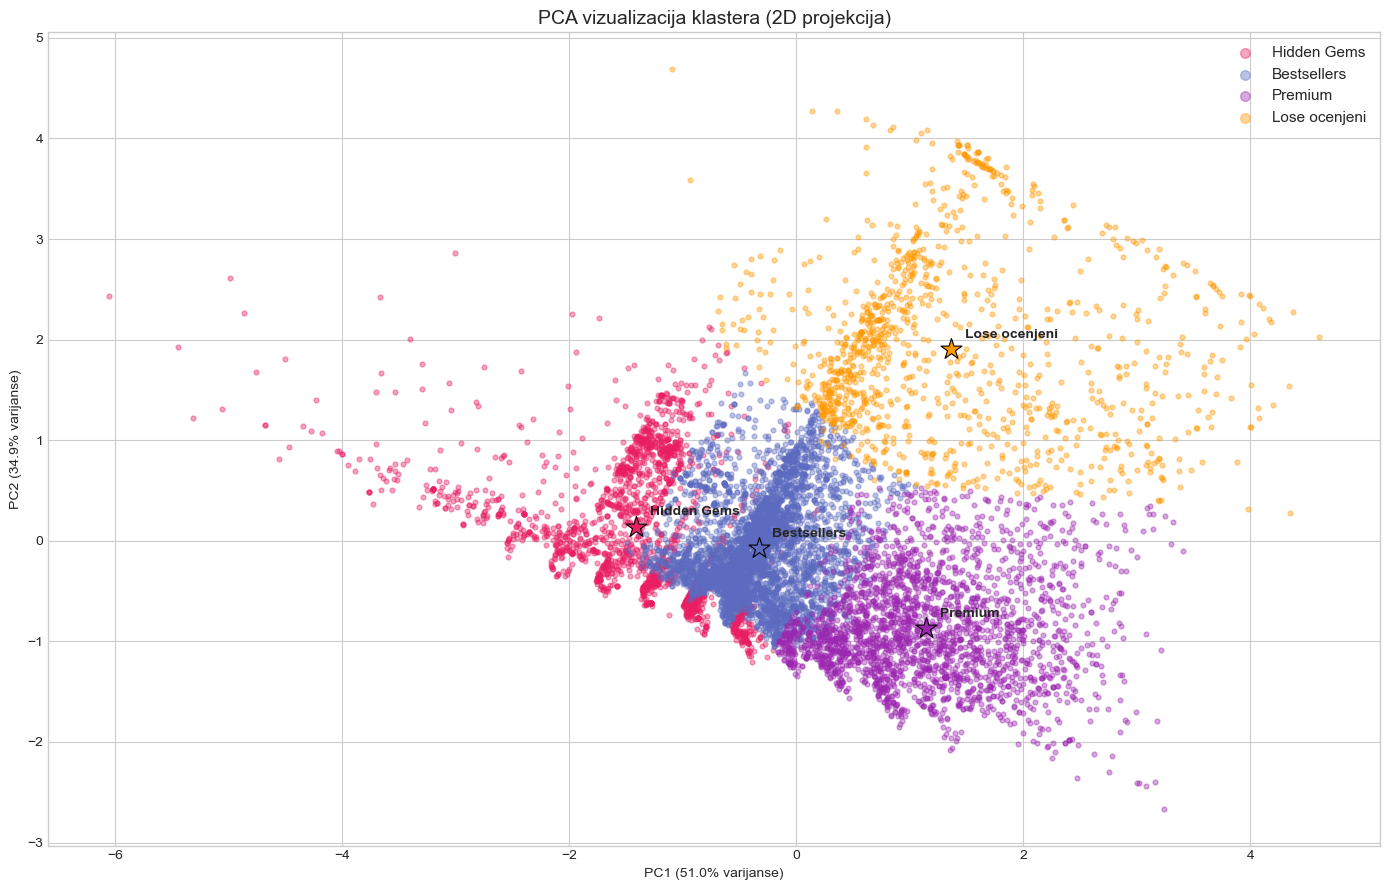

In [289]:
FINALNE_BOJE = {
    'Hidden Gems':    '#E91E63',
    'Bestsellers':     '#5C6BC0',
    'Premium':         '#9C27B0',
    'Lose ocenjeni':  '#FF9800',
}

fig, ax = plt.subplots(figsize=(14, 9))

for naziv, boja in FINALNE_BOJE.items():
    mask = df_rated['klaster_naziv_final'] == naziv
    ax.scatter(
        df_rated.loc[mask, 'pca_1'],
        df_rated.loc[mask, 'pca_2'],
        c=boja, label=naziv, alpha=0.4, s=12
    )

centroids_pca = pca.transform(kmeans_final.cluster_centers_)
for i, (cx, cy) in enumerate(centroids_pca):
    naziv = FINALNE_LABELE[i]
    boja = FINALNE_BOJE[naziv]
    ax.scatter(cx, cy, c=boja, s=250, marker='*', edgecolors='black', linewidth=0.8, zorder=5)
    ax.annotate(naziv, (cx, cy), textcoords='offset points', 
                xytext=(10, 8), fontsize=10, fontweight='bold')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varijanse)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varijanse)')
ax.set_title('PCA vizualizacija klastera (2D projekcija)', fontsize=14)
ax.legend(markerscale=2, fontsize=11)
plt.tight_layout()
plt.show()

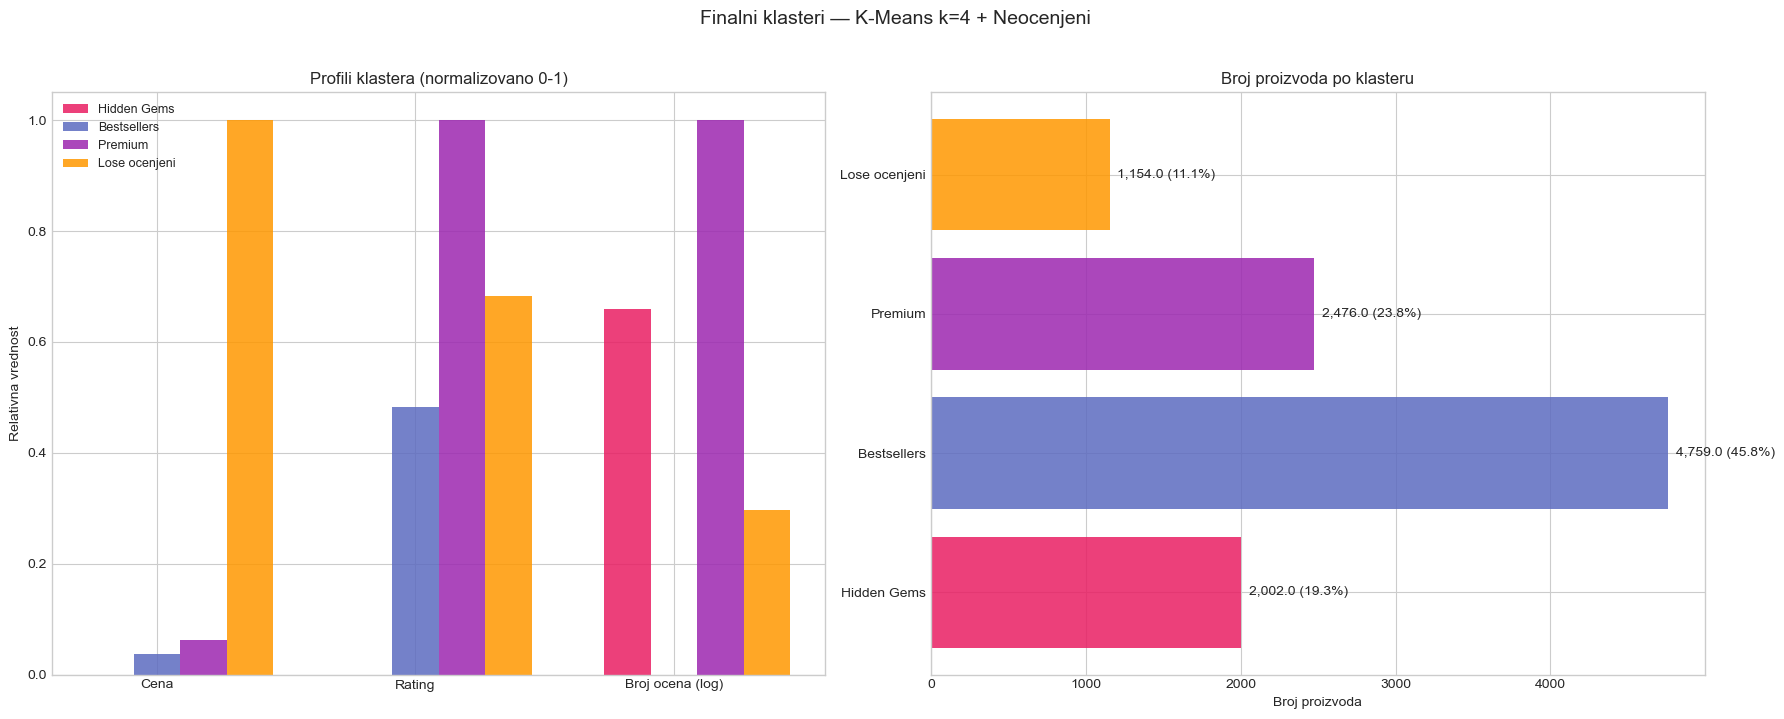

In [290]:
profil_viz = df_master.groupby('klaster_naziv_final').agg(
    avg_cena=('price_winsorized', 'mean'),
    avg_rating=('bayesian_rating', 'mean'),
    avg_noofratings_log=('noofratings_log', 'mean'),
    n_proizvoda=('price_winsorized', 'count')
).round(3)

profil_norm = (profil_viz[['avg_cena', 'avg_rating', 'avg_noofratings_log']] - 
               profil_viz[['avg_cena', 'avg_rating', 'avg_noofratings_log']].min()) / \
              (profil_viz[['avg_cena', 'avg_rating', 'avg_noofratings_log']].max() - 
               profil_viz[['avg_cena', 'avg_rating', 'avg_noofratings_log']].min())

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

x = np.arange(3)
feature_labels = ['Cena', 'Rating', 'Broj ocena (log)']
width = 0.18

klaster_order = ['Novi/Neocenjeni', 'Hidden Gems', 'Bestsellers', 'Premium', 'Lose ocenjeni']
boje_sve = ['#9E9E9E', '#E91E63', '#5C6BC0', '#9C27B0', '#FF9800']

for i, (naziv, boja) in enumerate(zip(klaster_order, boje_sve)):
    if naziv in profil_norm.index:
        axes[0].bar(x + i * width, profil_norm.loc[naziv].values, 
                    width, label=naziv, color=boja, alpha=0.85)

axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(feature_labels)
axes[0].set_title('Profili klastera (normalizovano 0-1)')
axes[0].set_ylabel('Relativna vrednost')
axes[0].legend(fontsize=9)

n_proizvoda = df_master['klaster_naziv_final'].value_counts().reindex(klaster_order)
axes[1].barh(klaster_order, n_proizvoda.values, color=boje_sve, alpha=0.85)
for i, v in enumerate(n_proizvoda.values):
    axes[1].text(v + 50, i, f'{v:,} ({v/len(df_master)*100:.1f}%)', 
                 va='center', fontsize=10)
axes[1].set_title('Broj proizvoda po klasteru')
axes[1].set_xlabel('Broj proizvoda')

plt.suptitle('Finalni klasteri — K-Means k=4 + Neocenjeni', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

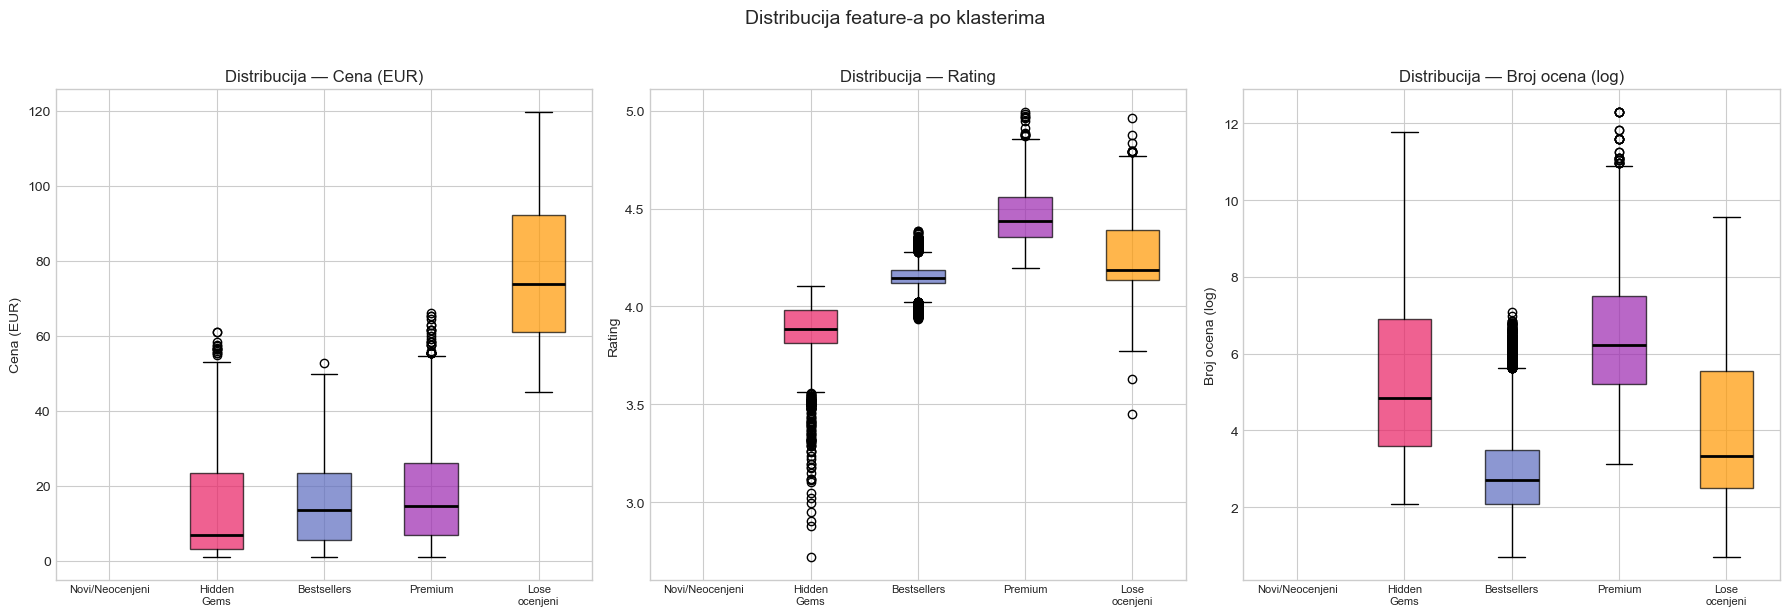

In [291]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

config = [
    ('price_winsorized', 'Cena (EUR)', COLORS['blue']),
    ('bayesian_rating',           'Rating',     COLORS['pink']),
    ('noofratings_log',  'Broj ocena (log)', COLORS['purple']),
]

for ax, (col, label, boja) in zip(axes, config):
    data_per_klaster = [
        df_master[df_master['klaster_naziv_final'] == naziv][col].dropna().values
        for naziv in klaster_order
    ]
    bp = ax.boxplot(data_per_klaster, patch_artist=True, vert=True)
    
    for patch, boja_k in zip(bp['boxes'], boje_sve):
        patch.set_facecolor(boja_k)
        patch.set_alpha(0.7)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)
    
    ax.set_xticklabels([n.split(' ')[0] + '\n' + n.split(' ')[1] 
                        if len(n.split(' ')) > 1 else n 
                        for n in klaster_order], fontsize=8)
    ax.set_title(f'Distribucija — {label}')
    ax.set_ylabel(label)

plt.suptitle('Distribucija feature-a po klasterima', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### UMAP vizualizacija

UMAP (Uniform Manifold Approximation and Projection) je nelinearna metoda redukcije dimenzionalnosti koja bolje čuva lokalnu strukturu podataka od PCA, što rezultuje jasnijim razdvajanjem klastera u 2D prikazu.

In [292]:
import umap

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = reducer.fit_transform(X_scaled_v3)

df_rated['umap_1'] = X_umap[:, 0]
df_rated['umap_2'] = X_umap[:, 1]

print("UMAP redukcija završena.")
print(f"Shape: {X_umap.shape}")


UMAP redukcija završena.
Shape: (10391, 2)


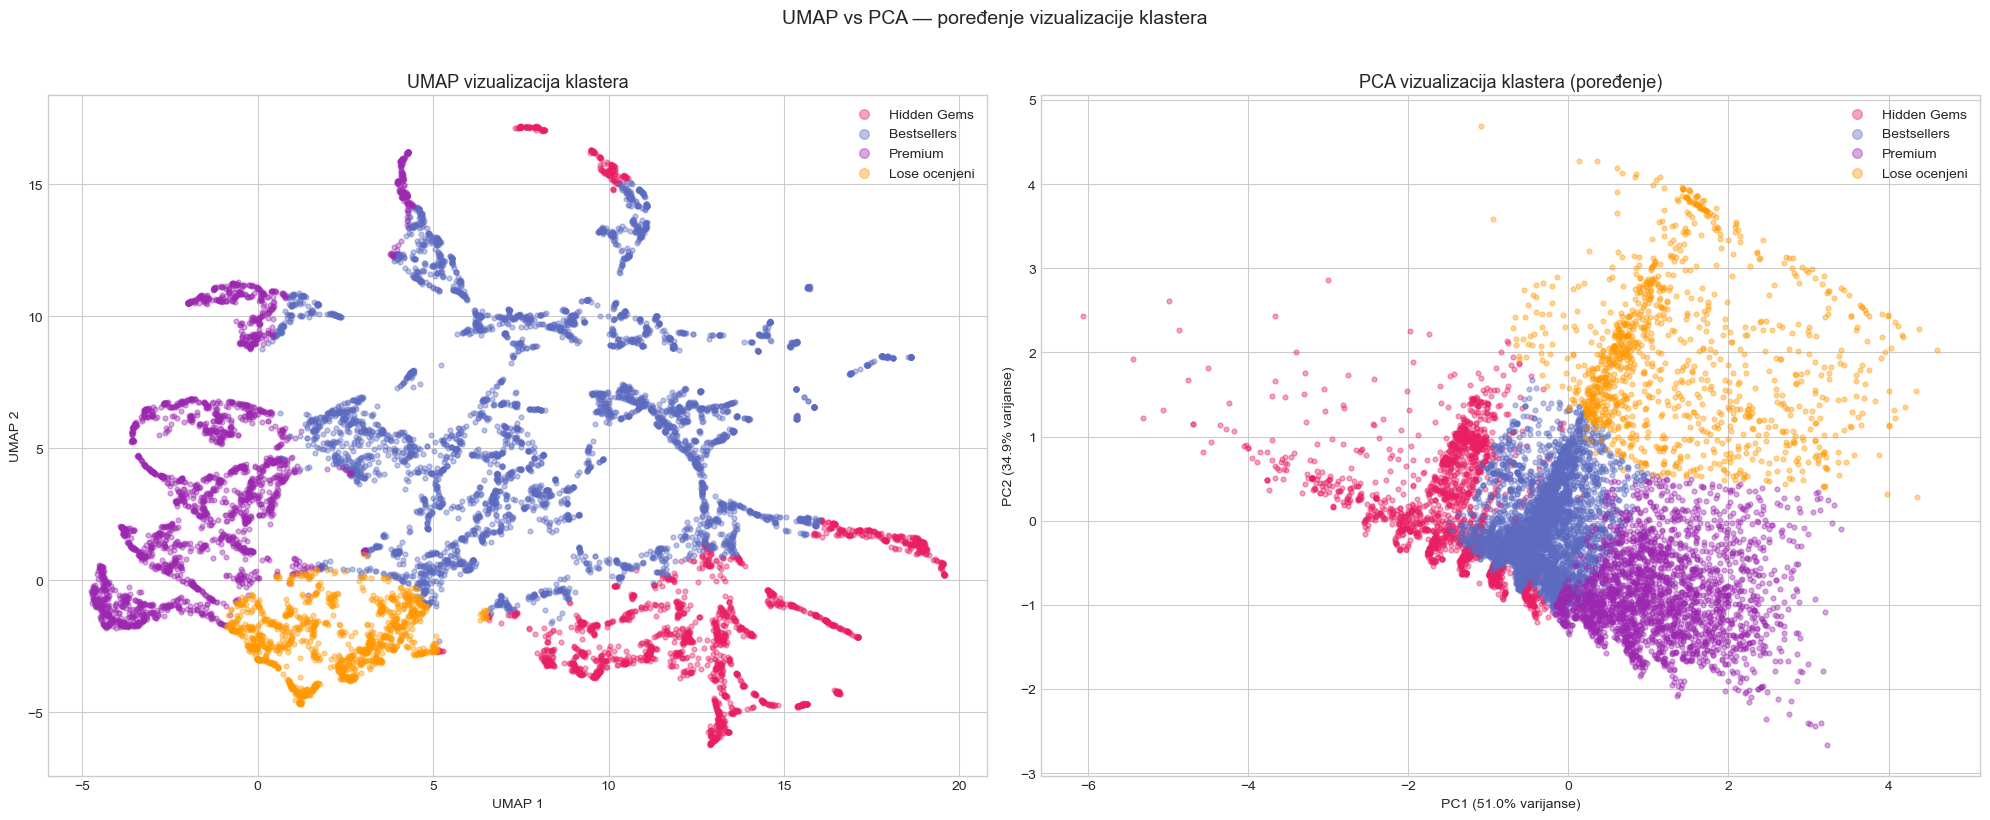

In [293]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for naziv, boja in FINALNE_BOJE.items():
    mask = df_rated['klaster_naziv_final'] == naziv
    axes[0].scatter(
        df_rated.loc[mask, 'umap_1'],
        df_rated.loc[mask, 'umap_2'],
        c=boja, label=naziv, alpha=0.4, s=12
    )

axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title('UMAP vizualizacija klastera', fontsize=13)
axes[0].legend(markerscale=2, fontsize=10)

for naziv, boja in FINALNE_BOJE.items():
    mask = df_rated['klaster_naziv_final'] == naziv
    axes[1].scatter(
        df_rated.loc[mask, 'pca_1'],
        df_rated.loc[mask, 'pca_2'],
        c=boja, label=naziv, alpha=0.4, s=12
    )

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varijanse)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varijanse)')
axes[1].set_title('PCA vizualizacija klastera (poređenje)', fontsize=13)
axes[1].legend(markerscale=2, fontsize=10)

plt.suptitle('UMAP vs PCA — poređenje vizualizacije klastera', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

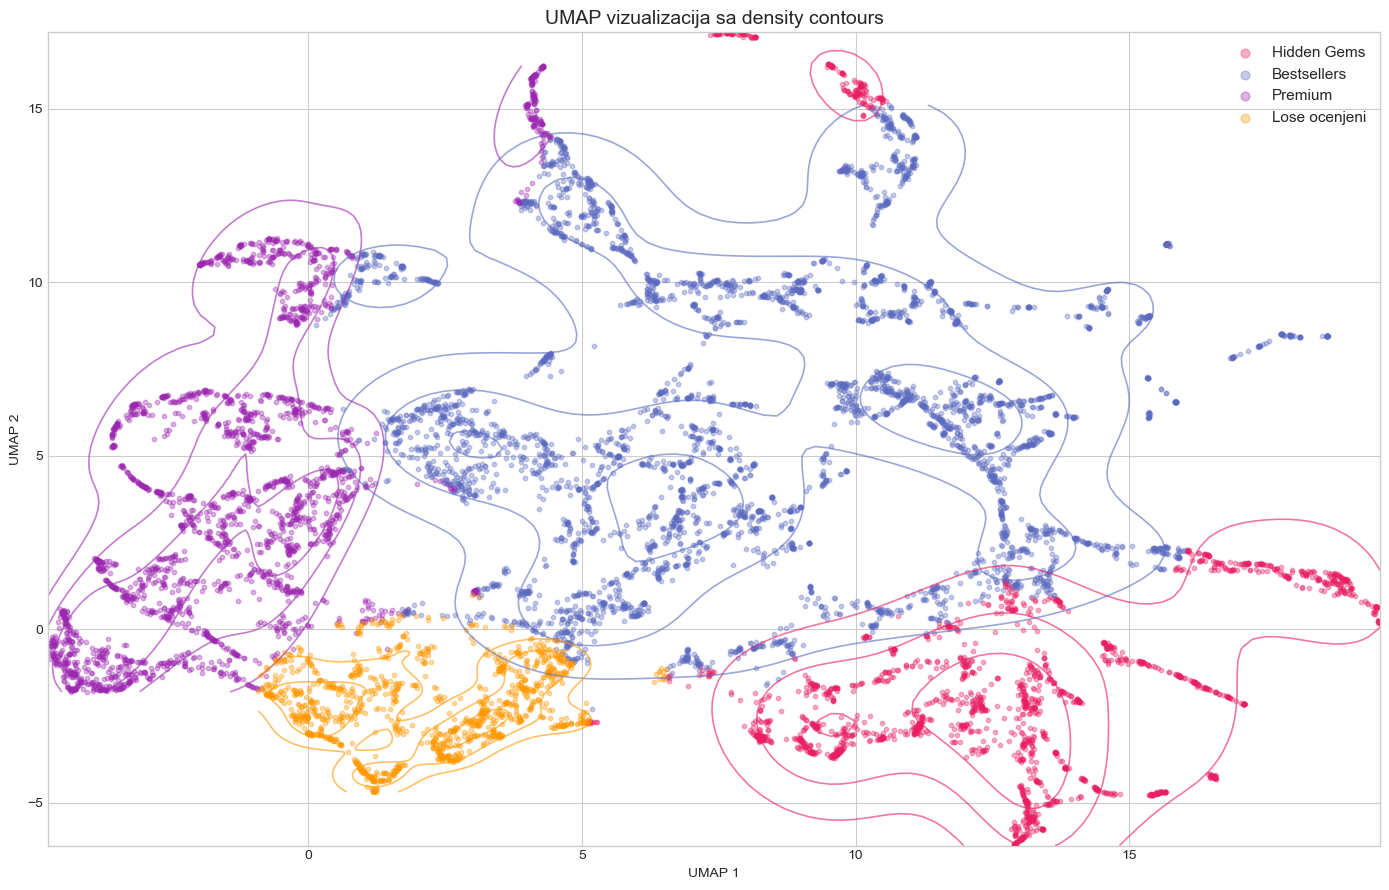

In [294]:
fig, ax = plt.subplots(figsize=(14, 9))

for naziv, boja in FINALNE_BOJE.items():
    mask = df_rated['klaster_naziv_final'] == naziv
    ax.scatter(
        df_rated.loc[mask, 'umap_1'],
        df_rated.loc[mask, 'umap_2'],
        c=boja, label=naziv, alpha=0.35, s=10
    )
    
    try:
        from scipy.stats import gaussian_kde
        x = df_rated.loc[mask, 'umap_1'].values
        y = df_rated.loc[mask, 'umap_2'].values
        if len(x) > 50:
            xy = np.vstack([x, y])
            kde = gaussian_kde(xy, bw_method=0.3)
            xmin, xmax = x.min(), x.max()
            ymin, ymax = y.min(), y.max()
            xx, yy = np.mgrid[xmin:xmax:80j, ymin:ymax:80j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            z = kde(positions).reshape(xx.shape)
            ax.contour(xx, yy, z, levels=3, colors=[boja], alpha=0.6, linewidths=1.2)
    except:
        pass

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('UMAP vizualizacija sa density contours', fontsize=14)
ax.legend(markerscale=2, fontsize=11)
plt.tight_layout()
plt.show()

## Analiza klastera sa kategorijama

Nakon klasterizacije analiziramo kako se kategorije i brendovi raspoređuju unutar svakog klastera.

In [295]:
df_cat_analysis = df_master[['klaster_naziv_final', 'category', 'subcategory', 
                              'brand', 'price_winsorized', 'bayesian_rating', 'noofratings_log']].copy()

print("Provera:")
print(f"Ukupno redova: {len(df_cat_analysis)}")
print(f"\nRaspodela po klasterima:")
display(df_cat_analysis['klaster_naziv_final'].value_counts())

Provera:
Ukupno redova: 10391

Raspodela po klasterima:


klaster_naziv_final
Bestsellers      4759
Premium          2476
Hidden Gems      2002
Lose ocenjeni    1154
Name: count, dtype: int64

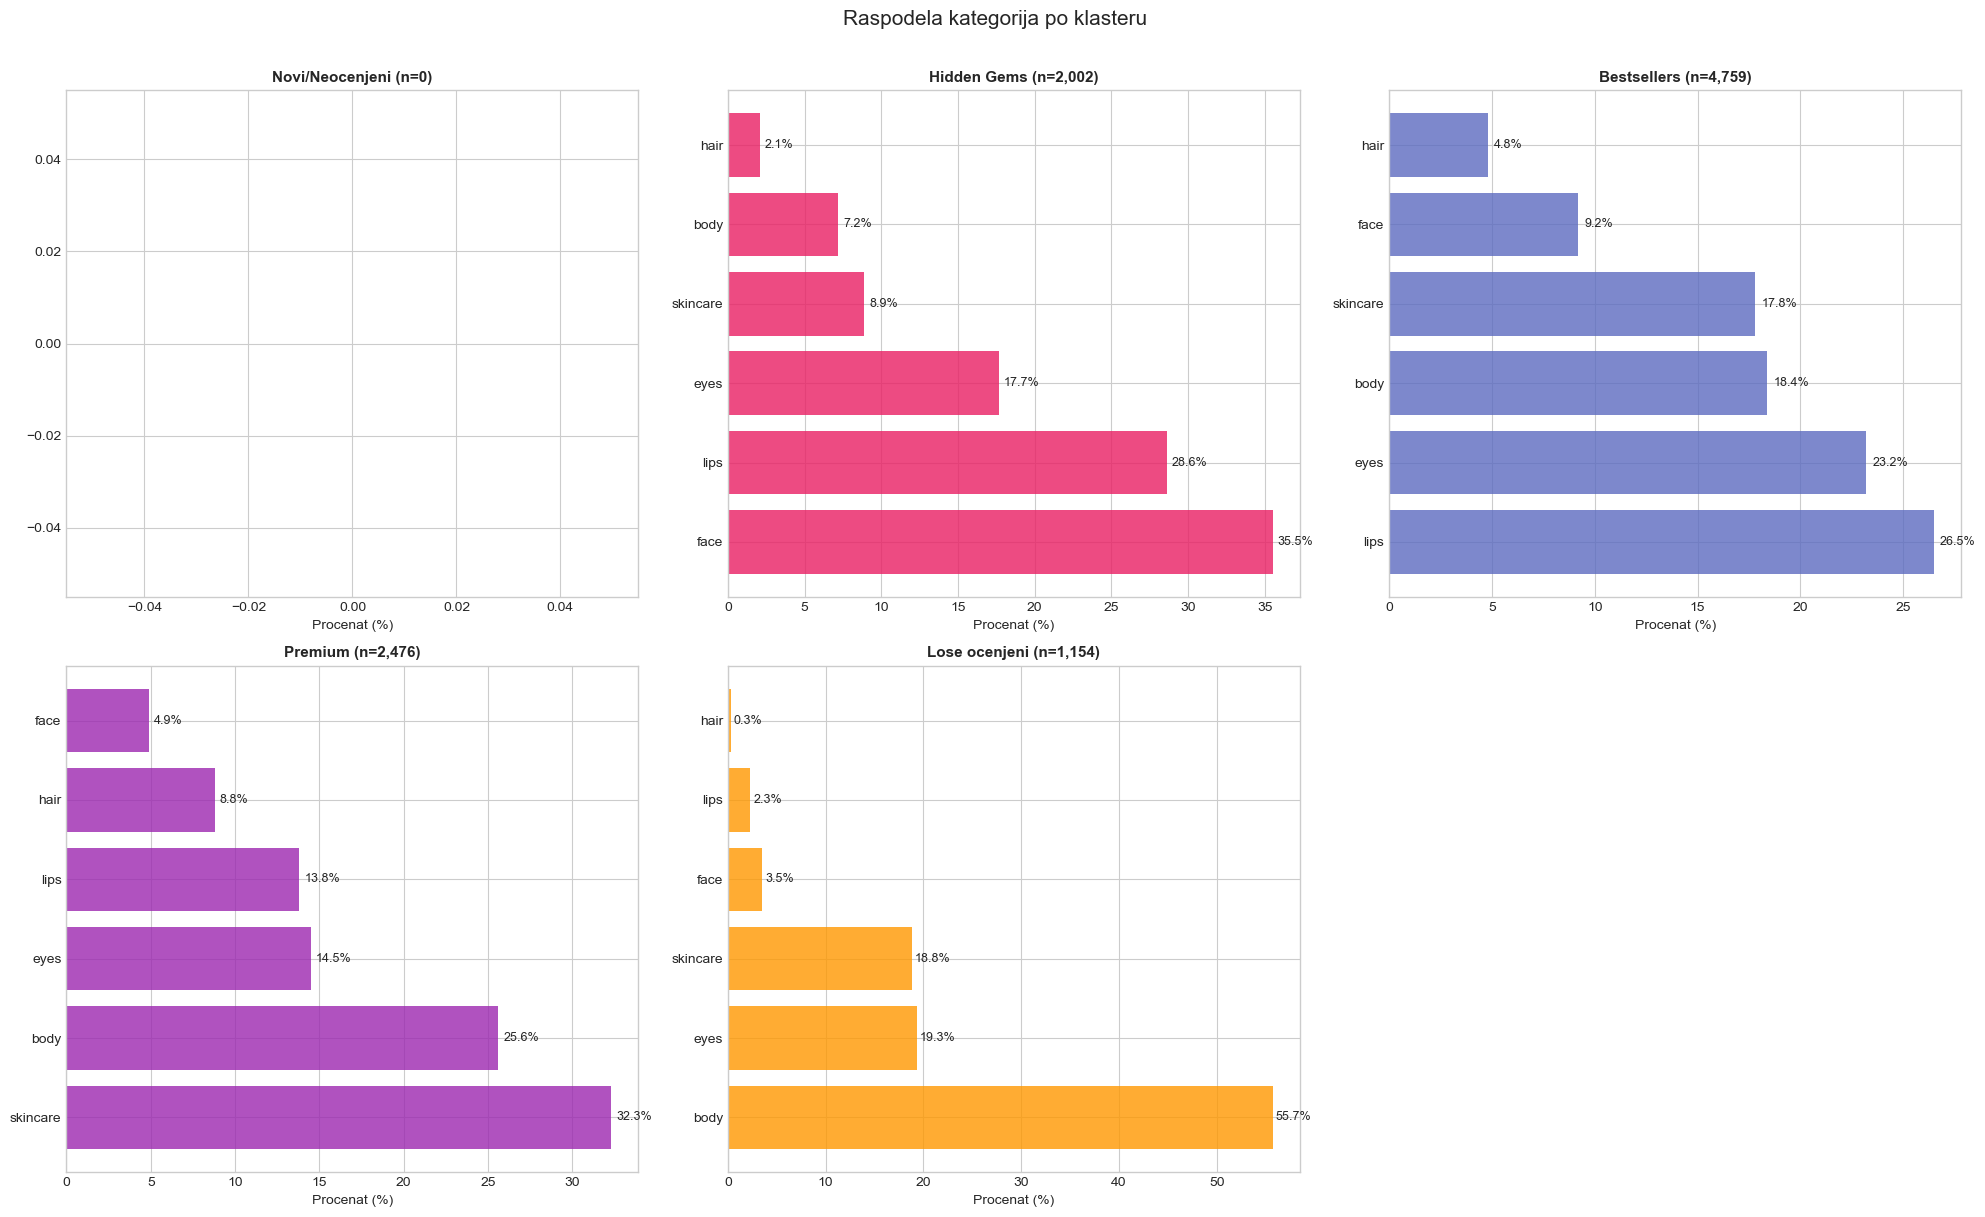

In [296]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

klaster_order_full = ['Novi/Neocenjeni', 'Hidden Gems', 'Bestsellers', 
                       'Premium', 'Lose ocenjeni']
boje_sve_full = ['#9E9E9E', '#E91E63', '#5C6BC0', '#9C27B0', '#FF9800']

for idx, (naziv, boja) in enumerate(zip(klaster_order_full, boje_sve_full)):
    mask = df_cat_analysis['klaster_naziv_final'] == naziv
    cat_counts = df_cat_analysis.loc[mask, 'category'].value_counts()
    cat_pct = (cat_counts / cat_counts.sum() * 100).round(1)
    
    bars = axes[idx].barh(cat_pct.index, cat_pct.values, color=boja, alpha=0.8)
    axes[idx].set_title(f'{naziv} (n={mask.sum():,})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Procenat (%)')
    
    for bar, val in zip(bars, cat_pct.values):
        axes[idx].text(val + 0.3, bar.get_y() + bar.get_height()/2, 
                      f'{val}%', va='center', fontsize=9)

fig.delaxes(axes[5])
plt.suptitle('Raspodela kategorija po klasteru', fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

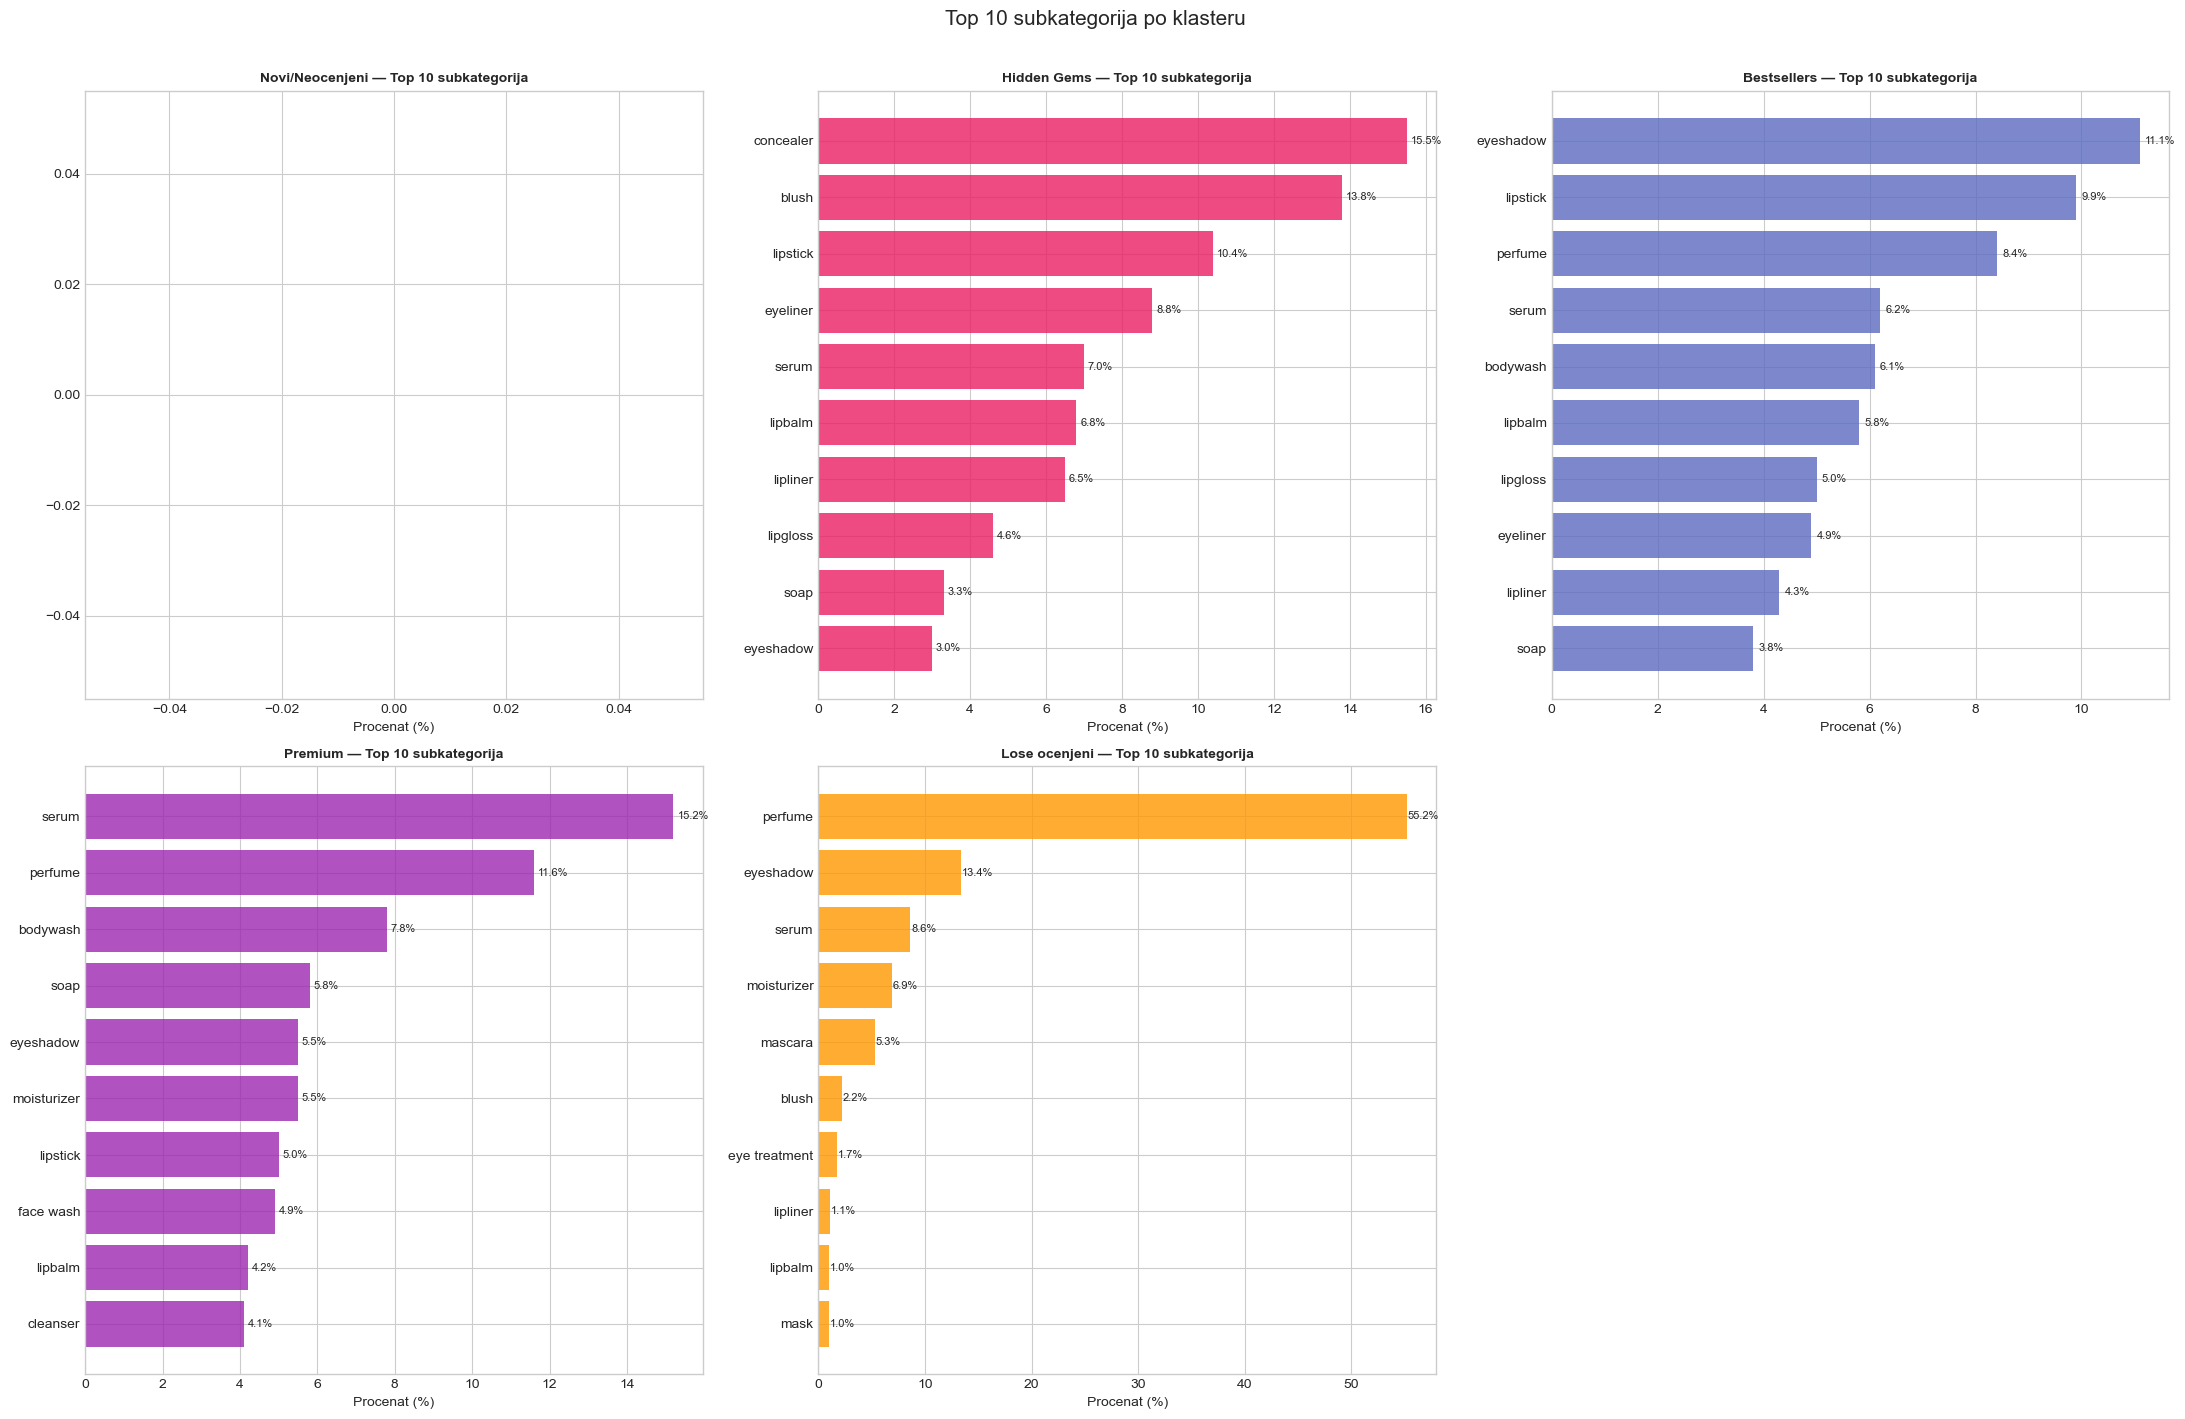

In [297]:
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
axes = axes.flatten()

for idx, (naziv, boja) in enumerate(zip(klaster_order_full, boje_sve_full)):
    mask = df_cat_analysis['klaster_naziv_final'] == naziv
    subcat_counts = df_cat_analysis.loc[mask, 'subcategory'].value_counts().head(10)
    subcat_pct = (subcat_counts / mask.sum() * 100).round(1)
    
    bars = axes[idx].barh(subcat_pct.index[::-1], subcat_pct.values[::-1], 
                          color=boja, alpha=0.8)
    axes[idx].set_title(f'{naziv} — Top 10 subkategorija', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Procenat (%)')
    
    for bar, val in zip(bars, subcat_pct.values[::-1]):
        axes[idx].text(val + 0.1, bar.get_y() + bar.get_height()/2,
                      f'{val}%', va='center', fontsize=8)

fig.delaxes(axes[5])
plt.suptitle('Top 10 subkategorija po klasteru', fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

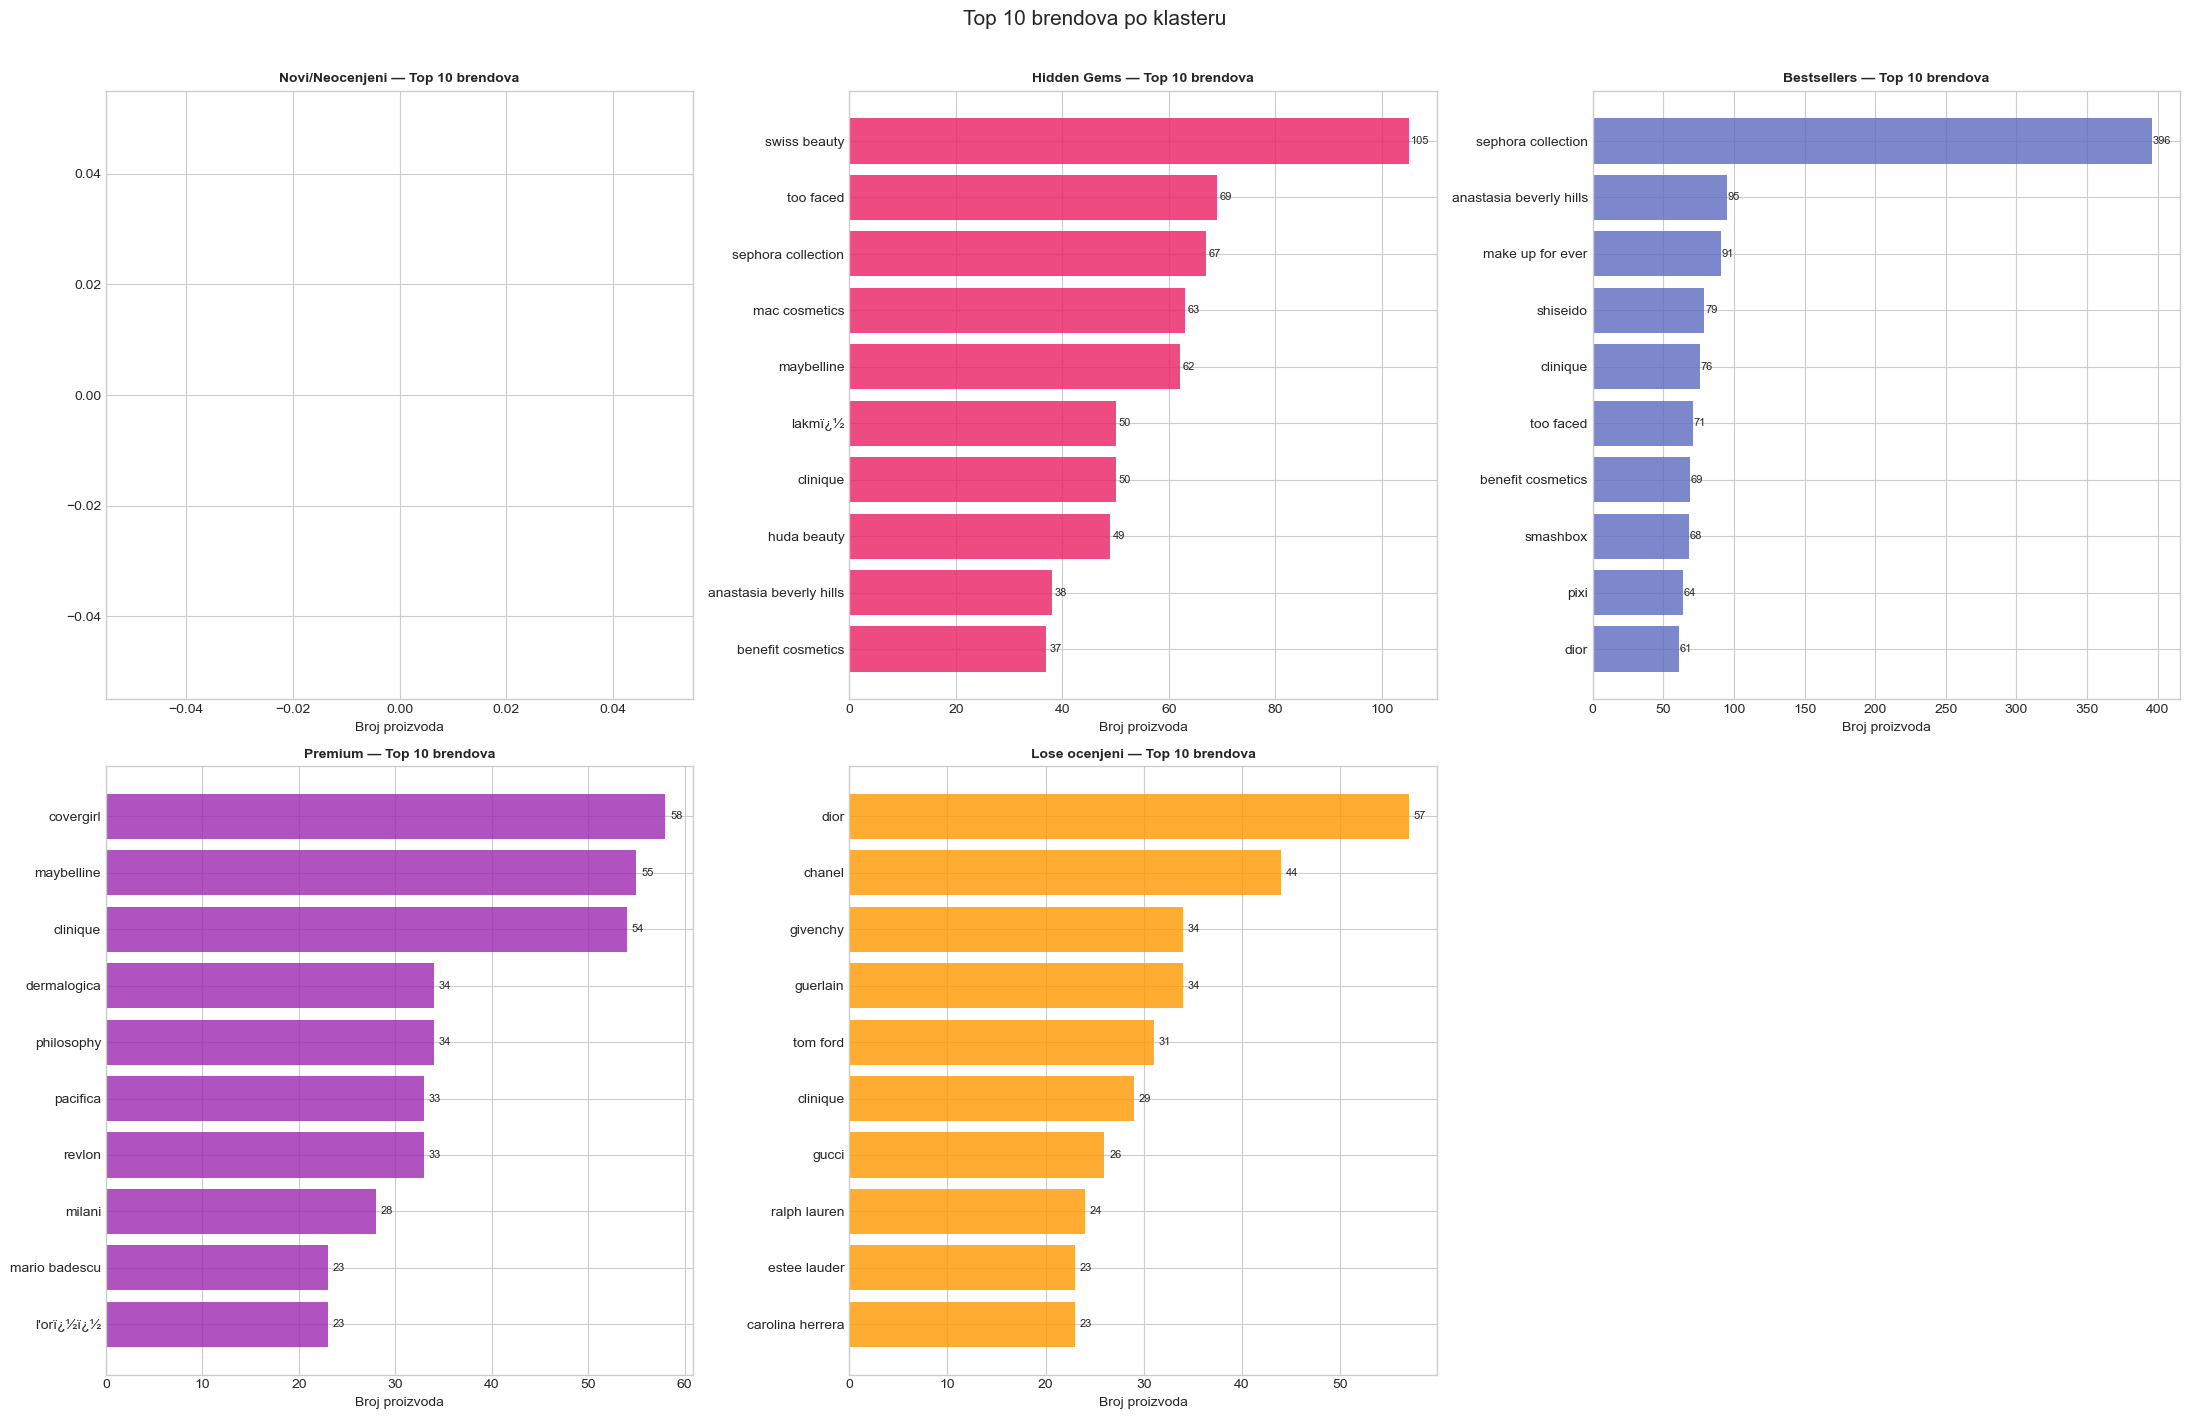

In [298]:
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
axes = axes.flatten()

for idx, (naziv, boja) in enumerate(zip(klaster_order_full, boje_sve_full)):
    mask = df_cat_analysis['klaster_naziv_final'] == naziv
    brand_counts = df_cat_analysis.loc[mask, 'brand'].value_counts().head(10)
    
    bars = axes[idx].barh(brand_counts.index[::-1], brand_counts.values[::-1],
                          color=boja, alpha=0.8)
    axes[idx].set_title(f'{naziv} — Top 10 brendova', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Broj proizvoda')
    
    for bar, val in zip(bars, brand_counts.values[::-1]):
        axes[idx].text(val + 0.5, bar.get_y() + bar.get_height()/2,
                      f'{val}', va='center', fontsize=8)

fig.delaxes(axes[5])
plt.suptitle('Top 10 brendova po klasteru', fontsize=15, y=1.01)
plt.tight_layout()
plt.show()